In [ ]:
!pip install kaggle

# Move the API key file to the appropriate location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


# Download the Kaggle dataset

!kaggle datasets download -d joe1995/div2k-dataset

100% 3.71G/3.71G [01:58<00:00, 31.6MB/s]
100% 3.71G/3.71G [01:58<00:00, 33.7MB/s]


In [ ]:
!unzip /content/div2k-dataset.zip -d destination-path

Archive:  /content/div2k-dataset.zip
  inflating: destination-path/DIV2K_train_HR/DIV2K_train_HR/0001.png  
  inflating: destination-path/DIV2K_train_HR/DIV2K_train_HR/0002.png  
  inflating: destination-path/DIV2K_train_HR/DIV2K_train_HR/0003.png  
  inflating: destination-path/DIV2K_train_HR/DIV2K_train_HR/0004.png  
  inflating: destination-path/DIV2K_train_HR/DIV2K_train_HR/0005.png  
  inflating: destination-path/DIV2K_train_HR/DIV2K_train_HR/0006.png  
  inflating: destination-path/DIV2K_train_HR/DIV2K_train_HR/0007.png  
  inflating: destination-path/DIV2K_train_HR/DIV2K_train_HR/0008.png  
  inflating: destination-path/DIV2K_train_HR/DIV2K_train_HR/0009.png  
  inflating: destination-path/DIV2K_train_HR/DIV2K_train_HR/0010.png  
  inflating: destination-path/DIV2K_train_HR/DIV2K_train_HR/0011.png  
  inflating: destination-path/DIV2K_train_HR/DIV2K_train_HR/0012.png  
  inflating: destination-path/DIV2K_train_HR/DIV2K_train_HR/0013.png  
  inflating: destination-path/DIV2K_trai

In [ ]:
### Imports ###
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import tensorflow as tf

import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
from tensorflow.keras.preprocessing import image
import os
import random
import numpy as np

from PIL import Image  # Importing Pillow as 'Image'

# Constants
TRAIN_DIR = "/content/destination-path/DIV2K_train_HR/DIV2K_train_HR"
VALID_DIR = "/content/destination-path/DIV2K_valid_HR/DIV2K_valid_HR"  # Path to training directory
IMG_SHAPE = (64, 64)

def load_dataset(batch_size=32):
    """Loads the training dataset in batches.

    Arguments:
        batch_size: number of images per batch to load into the training dataset.
    """
    X_train = []
    X_val = []

    # Assuming all images are directly within the TRAIN_DIR
    train_imgs = os.listdir(TRAIN_DIR)
    valid_imgs = os.listdir(VALID_DIR)
    random.shuffle(train_imgs)
    random.shuffle(valid_imgs)

    num_train_batches = len(train_imgs) // batch_size
    num_valid_batches = len(valid_imgs) // batch_size


    for batch in range(num_train_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size

        batch_imgs = train_imgs[start_idx:end_idx]

        for img_name_i in batch_imgs:
            img_path_i = os.path.join(TRAIN_DIR, img_name_i)

            try:
                # Open image using Pillow
                img_i = Image.open(img_path_i)
                # Resize image
                img_i = img_i.resize(IMG_SHAPE)
                # Convert to numpy array
                x = np.array(img_i)
                X_train.append(x)
            except Exception as e:
                print(f"Error loading image {img_path_i}: {e}")

    X_train = np.array(X_train)

    for batch in range(num_valid_batches):
          start_idx = batch * batch_size
          end_idx = (batch + 1) * batch_size

          batch_imgs = valid_imgs[start_idx:end_idx]

          for img_name_i in batch_imgs:
              img_path_i = os.path.join(VALID_DIR, img_name_i)

              try:
                  # Open image using Pillow
                  img_i = Image.open(img_path_i)
                  # Resize image
                  img_i = img_i.resize(IMG_SHAPE)
                  # Convert to numpy array
                  x = np.array(img_i)
                  X_val.append(x)
              except Exception as e:
                  print(f"Error loading image {img_path_i}: {e}")

    # Convert the list to a numpy array

    X_val = np.array(X_val)
    return X_train, X_val

# Example usage:
batch_size = 32  # Adjust as needed
X_train, X_val = load_dataset(batch_size)


In [ ]:
X_train.shape

(800, 64, 64, 3)

In [ ]:
  # Load dataset.
  # X_train_orig, X_test_orig = load_dataset_small()
  X_train_orig, X_val_orig = load_dataset()

  # Normalize image vectors.
  X_train = X_train_orig/255.
  X_val = X_val_orig/255.

  # Print statistics.
  print ("Number of training examples = " + str(X_train.shape[0]))
  print ("Number of test examples = " + str(X_val.shape[0]))
  print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 800
Number of test examples = 96
X_train shape: (800, 64, 64, 3)


In [ ]:
# Split the training set into two halves.
# The first half is used for secret images, and the second half for cover images.

# Secret Images
input_train_S1 = X_train[:X_train.shape[0] // 2]
input_val_S1 = X_val[:X_val.shape[0]//2]

# Cover Images
input_train_C = X_train[X_train.shape[0] // 2 :]
input_val_C = X_val[X_val.shape[0] // 2 :]



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, concatenate, Dropout, Lambda, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
from tensorflow.nn import depth_to_space


# Constants
input_size = (64, 64, 3)  # Adjust the size as needed

# # Load the VGG16 model with pre-trained weights (without the top classification layers)
# vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# # Set VGG layers to non-trainable
# for layer in vgg_model.layers:
#     layer.trainable = False

# def perceptual_loss(y_true, y_pred):
#     # Get the layer outputs for the VGG model
#     vgg_outputs = [vgg_model.get_layer(name).output for name in ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3']]

#     # Create a new model that outputs feature maps from the specified VGG layers
#     vgg_feature_extractor = Model(inputs=vgg_model.input, outputs=vgg_outputs)

#     # Compute feature maps for both true and predicted images
#     true_features = vgg_feature_extractor(y_true)
#     pred_features = vgg_feature_extractor(y_pred)

#     # Calculate the mean squared error (MSE) between the feature maps
#     loss = tf.reduce_mean([tf.reduce_mean(tf.square(true - pred)) for true, pred in zip(true_features, pred_features)])

#     return loss
def color_histogram_loss(y_true, y_pred, bins=256):
    # Ensure that the image pixel values are scaled to the range [0, 255] if they are originally [0, 1]
    y_true_int = tf.cast(y_true * 255, tf.int32)
    y_pred_int = tf.cast(y_pred * 255, tf.int32)

    # Calculate the histograms
    hist_true = tf.histogram_fixed_width(y_true_int, [0, 255], nbins=bins, dtype=tf.int32)
    hist_pred = tf.histogram_fixed_width(y_pred_int, [0, 255], nbins=bins, dtype=tf.int32)

    # Calculate the histogram loss as the mean squared difference between histograms
    # and make sure the result is float32
    loss = tf.cast(tf.reduce_mean(tf.square(hist_true - hist_pred)), tf.float32)

    return loss

def ssim_loss(y_true, y_pred):
    return 1 - K.mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def psnr_loss(y_true, y_pred):
    # Ensure that the image pixel values are scaled to the range [0, 255] if they are originally [0, 1]
    y_true_int = tf.cast(y_true * 255, tf.int32)
    y_pred_int = tf.cast(y_pred * 255, tf.int32)

    # Calculate the PSNR loss
    mse = tf.reduce_mean(tf.square(y_true_int - y_pred_int), axis=-1)
    psnr = tf.reduce_mean(20 * tf.math.log(255.0 / tf.sqrt(mse)), axis=-1)

    return -psnr  # Negative PSNR to minimize it

# Combined MSE, SSIM, and Histogram loss
def combined_loss(y_true, y_pred):
    alpha = 0.5  # Weight for SSIM
    beta = 0.2   # Weight for MSE
    gamma = 0.06
    delta = 0.2 # Weight for color histogram loss, adjust as necessary

    mse_loss = K.mean(K.square(y_true - y_pred), axis=-1)
    ssim_l = ssim_loss(y_true, y_pred)
    histogram_l = color_histogram_loss(y_true, y_pred)
    psnr_l = psnr_loss(y_true, y_pred)

    # Ensure all losses are float32 before combining
    mse_loss = K.cast(mse_loss, 'float32')
    ssim_l = K.cast(ssim_l, 'float32')
    histogram_l = K.cast(histogram_l, 'float32')
    psnr_l = K.cast(psnr_l, 'float32')

    # Combine the losses
    combined = alpha * mse_loss + beta * ssim_l + gamma * histogram_l + delta * psnr_l

    return combined


def full_loss(y_true, y_pred):
    s_true, c_true = y_true[..., 0:3], y_true[..., 3:6]
    s_pred, c_pred = y_pred[..., 0:3], y_pred[..., 3:6]

    s_loss = combined_loss(s_true, s_pred)
    c_loss = combined_loss(c_true, c_pred)

    # Assuming you want to apply the same weighting to both perceptual losses
    alpha = 0.01  # You can adjust this weight
    return s_loss + c_loss


def SubpixelConv2D(scale):
    return Lambda(lambda x: depth_to_space(x, scale))

# Returns the encoder as a Keras model
def make_encoder(input_size):
    input_S1 = Input(shape=input_size, name='input_S1')
    input_C = Input(shape=input_size, name='input_C')

    # Preparation Network
    print('dim', input_S1.shape)
    x3 = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_prep0_3x3_1')(input_S1)
    x3 = LeakyReLU(alpha=0.01)(x3)
    pool_x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
    norm_x3 = BatchNormalization()(pool_x3)
    dropout_x3 = Dropout(0.1)(norm_x3)
    x3 = SubpixelConv2D(2)(dropout_x3)
    print('dim', x3.shape)
    x4 = Conv2D(256, (4, 4), strides=(1, 1), padding='same', name='conv_prep0_4x4_1')(input_S1)
    x4 = LeakyReLU(alpha=0.01)(x4)
    pool_x4 = MaxPooling2D(pool_size=(2, 2), padding='same')(x4)
    norm_x4 = BatchNormalization()(pool_x4)
    dropout_x4 = Dropout(0.1)(norm_x4)
    x4 = SubpixelConv2D(2)(dropout_x4)
    x5 = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv_prep0_5x5_1')(input_S1)
    x5 = LeakyReLU(alpha=0.01)(x5)
    pool_x5 = MaxPooling2D(pool_size=(2, 2), padding='same')(x5)
    norm_x5 = BatchNormalization()(pool_x5)
    dropout_x5 = Dropout(0.1)(norm_x5)
    x5 = SubpixelConv2D(2)(dropout_x5)
    print('here1')
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_prep1_3x3_1')(x)
    x3 = LeakyReLU(alpha=0.01)(x3)
    pool_x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
    norm_x3 = BatchNormalization()(pool_x3)
    dropout_x3 = Dropout(0.1)(norm_x3)
    x3 = SubpixelConv2D(2)(dropout_x3)
    x4 = Conv2D(256, (4, 4), strides=(1, 1), padding='same', name='conv_prep1_4x4_1')(x)
    x4 = LeakyReLU(alpha=0.01)(x4)
    pool_x4 = MaxPooling2D(pool_size=(2, 2), padding='same')(x4)
    norm_x4 = BatchNormalization()(pool_x4)
    dropout_x4 = Dropout(0.1)(norm_x4)
    x4 = SubpixelConv2D(2)(dropout_x4)
    x5 = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv_prep1_5x5_1')(x)
    x5 = LeakyReLU(alpha=0.01)(x5)
    pool_x5 = MaxPooling2D(pool_size=(2, 2), padding='same')(x5)
    norm_x5 = BatchNormalization()(pool_x5)
    dropout_x5 = Dropout(0.1)(norm_x5)
    x5 = SubpixelConv2D(2)(dropout_x5)
    print('here2')
    x1 = concatenate([x3, x4, x5])

    # x3 = Conv2D(50, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv_prep0_3x3_2')(input_C)
    # # x4 = Conv2D(10, (4, 4), strides=(1, 1), padding='same', activation='relu', name='conv_prep0_4x4_2')(input_C)
    # # x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_prep0_5x5_2')(input_C)
    # # x = concatenate([x3, x4, x5])

    # x3 = Conv2D(50, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv_prep1_3x3_2')(x3)
    # # x4 = Conv2D(10, (4, 4), strides=(1, 1), padding='same', activation='relu', name='conv_prep1_4x4_2')(x)
    # # x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_prep1_5x5_2')(x)
    # x2 = concatenate([x3, x4, x5])

    x = concatenate([input_C, x1])

    x3 = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_hid0_3x3')(x)
    x3 = LeakyReLU(alpha=0.01)(x3)
    pool_x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
    norm_x3 = BatchNormalization()(pool_x3)
    dropout_x3 = Dropout(0.1)(norm_x3)
    x3 = SubpixelConv2D(2)(dropout_x3)
    x4 = Conv2D(256, (4, 4), strides=(1, 1), padding='same', name='conv_hid0_4x4')(x)
    x4 = LeakyReLU(alpha=0.01)(x4)
    pool_x4 = MaxPooling2D(pool_size=(2, 2), padding='same')(x4)
    norm_x4 = BatchNormalization()(pool_x4)
    dropout_x4 = Dropout(0.1)(norm_x4)
    x4 = SubpixelConv2D(2)(dropout_x4)
    x5 = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv_hid0_5x5')(x)
    x5 = LeakyReLU(alpha=0.01)(x5)
    pool_x5 = MaxPooling2D(pool_size=(2, 2), padding='same')(x5)
    norm_x5 = BatchNormalization()(pool_x5)
    dropout_x5 = Dropout(0.1)(norm_x5)
    x5 = SubpixelConv2D(2)(dropout_x5)
    print('here3')
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_hid1_3x3')(x)
    x3 = LeakyReLU(alpha=0.01)(x3)
    pool_x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
    norm_x3 = BatchNormalization()(pool_x3)
    dropout_x3 = Dropout(0.1)(norm_x3)
    x3 = SubpixelConv2D(2)(dropout_x3)
    x4 = Conv2D(256, (4, 4), strides=(1, 1), padding='same', name='conv_hid1_4x4')(x)
    x4 = LeakyReLU(alpha=0.01)(x4)
    pool_x4 = MaxPooling2D(pool_size=(2, 2), padding='same')(x4)
    norm_x4 = BatchNormalization()(pool_x4)
    dropout_x4 = Dropout(0.1)(norm_x4)
    x4 = SubpixelConv2D(2)(dropout_x4)
    x5 = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv_hid1_5x5')(x)
    x5 = LeakyReLU(alpha=0.01)(x5)
    pool_x5 = MaxPooling2D(pool_size=(2, 2), padding='same')(x5)
    norm_x5 = BatchNormalization()(pool_x5)
    dropout_x5 = Dropout(0.1)(norm_x5)
    x5 = SubpixelConv2D(2)(dropout_x5)
    print('here4')
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_hid2_3x3')(x)
    x3 = LeakyReLU(alpha=0.01)(x3)
    pool_x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
    norm_x3 = BatchNormalization()(pool_x3)
    dropout_x3 = Dropout(0.1)(norm_x3)
    x3 = SubpixelConv2D(2)(dropout_x3)
    x4 = Conv2D(256, (4, 4), strides=(1, 1), padding='same', name='conv_hid2_4x4')(x)
    x4 = LeakyReLU(alpha=0.01)(x4)
    pool_x4 = MaxPooling2D(pool_size=(2, 2), padding='same')(x4)
    norm_x4 = BatchNormalization()(pool_x4)
    dropout_x4 = Dropout(0.1)(norm_x4)
    x4 = SubpixelConv2D(2)(dropout_x4)
    x5 = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv_hid2_5x5')(x)
    x5 = LeakyReLU(alpha=0.01)(x5)
    pool_x5 = MaxPooling2D(pool_size=(2, 2), padding='same')(x5)
    norm_x5 = BatchNormalization()(pool_x5)
    dropout_x5 = Dropout(0.1)(norm_x5)
    x5 = SubpixelConv2D(2)(dropout_x5)
    print('here5')
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_hid3_3x3')(x)
    x3 = LeakyReLU(alpha=0.01)(x3)
    pool_x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
    norm_x3 = BatchNormalization()(pool_x3)
    dropout_x3 = Dropout(0.1)(norm_x3)
    x3 = SubpixelConv2D(2)(dropout_x3)
    x4 = Conv2D(256, (4, 4), strides=(1, 1), padding='same', name='conv_hid3_4x4')(x)
    x4 = LeakyReLU(alpha=0.01)(x4)
    pool_x4 = MaxPooling2D(pool_size=(2, 2), padding='same')(x4)
    norm_x4 = BatchNormalization()(pool_x4)
    dropout_x4 = Dropout(0.1)(norm_x4)
    x4 = SubpixelConv2D(2)(dropout_x4)
    x5 = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv_hid3_5x5')(x)
    x5 = LeakyReLU(alpha=0.01)(x5)
    pool_x5 = MaxPooling2D(pool_size=(2, 2), padding='same')(x5)
    norm_x5 = BatchNormalization()(pool_x5)
    dropout_x5 = Dropout(0.1)(norm_x5)
    x5 = SubpixelConv2D(2)(dropout_x5)
    print('here6')
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_hid4_3x3')(x)
    x3 = LeakyReLU(alpha=0.01)(x3)
    pool_x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
    norm_x3 = BatchNormalization()(pool_x3)
    dropout_x3 = Dropout(0.1)(norm_x3)
    x3 = SubpixelConv2D(2)(dropout_x3)
    x4 = Conv2D(256, (4, 4), strides=(1, 1), padding='same', name='conv_hid4_4x4')(x)
    x4 = LeakyReLU(alpha=0.01)(x4)
    pool_x4 = MaxPooling2D(pool_size=(2, 2), padding='same')(x4)
    norm_x4 = BatchNormalization()(pool_x4)
    dropout_x4 = Dropout(0.1)(norm_x4)
    x4 = SubpixelConv2D(2)(dropout_x4)
    x5 = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv_hid4_5x5')(x)
    x5 = LeakyReLU(alpha=0.01)(x5)
    pool_x5 = MaxPooling2D(pool_size=(2, 2), padding='same')(x5)
    norm_x5 = BatchNormalization()(pool_x5)
    dropout_x5 = Dropout(0.1)(norm_x5)
    x5 = SubpixelConv2D(2)(dropout_x5)
    print('here7')
    x = concatenate([x3, x4, x5])
    print('x3 : ', x3.shape)
    print('x : ', x.shape)
    xf = Conv2D(3, (3, 3), strides=(1, 1), padding='same', activation='sigmoid', name='conv_hid_final')(x)

    # Adding Gaussian noise to the hidden image
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_Cp')(xf)
    print(output_Cprime.shape)

    return Model(inputs=[input_S1, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')
# Returns the decoder as a Keras model
def make_decoder(input_size):
    reveal_input = Input(shape=input_size, name='reveal_input')

    x3 = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_rev0_3x3')(reveal_input)
    x3 = LeakyReLU(alpha=0.01)(x3)
    pool_x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
    norm_x3 = BatchNormalization()(pool_x3)
    dropout_x3 = Dropout(0.1)(norm_x3)
    x3 = SubpixelConv2D(2)(dropout_x3)
    x4 = Conv2D(256, (4, 4), strides=(1, 1), padding='same', name='conv_rev0_4x4')(reveal_input)
    x4 = LeakyReLU(alpha=0.01)(x4)
    pool_x4 = MaxPooling2D(pool_size=(2, 2), padding='same')(x4)
    norm_x4 = BatchNormalization()(pool_x4)
    dropout_x4 = Dropout(0.1)(norm_x4)
    x4 = SubpixelConv2D(2)(dropout_x4)
    x5 = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv_rev0_5x5')(reveal_input)
    x5 = LeakyReLU(alpha=0.01)(x5)
    pool_x5 = MaxPooling2D(pool_size=(2, 2), padding='same')(x5)
    norm_x5 = BatchNormalization()(pool_x5)
    dropout_x5 = Dropout(0.1)(norm_x5)
    x5 = SubpixelConv2D(2)(dropout_x5)
    xf_1 = concatenate([x3, x4, x5])

    # x3 = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_rev1_3x3')(xf_1)
    # x3 = LeakyReLU(alpha=0.01)(x3)
    # pool_x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
    # norm_x3 = BatchNormalization()(pool_x3)
    # dropout_x3 = Dropout(0.1)(norm_x3)
    # x3 = SubpixelConv2D(2)(dropout_x3)
    # x4 = Conv2D(256, (4, 4), strides=(1, 1), padding='same', name='conv_rev1_4x4')(xf_1)
    # x4 = LeakyReLU(alpha=0.01)(x4)
    # pool_x4 = MaxPooling2D(pool_size=(2, 2), padding='same')(x4)
    # norm_x4 = BatchNormalization()(pool_x3)
    # dropout_x4 = Dropout(0.1)(norm_x4)
    # x4 = SubpixelConv2D(2)(dropout_x4)
    # x5 = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv_rev1_5x5')(xf_1)
    # x5 = LeakyReLU(alpha=0.01)(x5)
    # pool_x5 = MaxPooling2D(pool_size=(2, 2), padding='same')(x5)
    # norm_x5 = BatchNormalization()(pool_x5)
    # dropout_x5 = Dropout(0.1)(norm_x5)
    # x5 = SubpixelConv2D(2)(dropout_x5)
    # xf_2 = concatenate([x3, x4, x5])


    # x3 = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_rev2_3x3')(xf_2)
    # x3 = LeakyReLU(alpha=0.01)(x3)
    # pool_x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
    # norm_x3 = BatchNormalization()(pool_x3)
    # dropout_x3 = Dropout(0.1)(norm_x3)
    # x3 = SubpixelConv2D(2)(dropout_x3)
    # x4 = Conv2D(256, (4, 4), strides=(1, 1), padding='same', name='conv_rev2_4x4')(xf_2)
    # x4 = LeakyReLU(alpha=0.01)(x4)
    # pool_x4 = MaxPooling2D(pool_size=(2, 2), padding='same')(x4)
    # norm_x4 = BatchNormalization()(pool_x3)
    # dropout_x4 = Dropout(0.1)(norm_x4)
    # x4 = SubpixelConv2D(2)(dropout_x4)
    # x5 = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv_rev2_5x5')(xf_2)
    # x5 = LeakyReLU(alpha=0.01)(x5)
    # pool_x5 = MaxPooling2D(pool_size=(2, 2), padding='same')(x5)
    # norm_x5 = BatchNormalization()(pool_x5)
    # dropout_x5 = Dropout(0.1)(norm_x5)
    # x5 = SubpixelConv2D(2)(dropout_x5)
    # xf_3 = concatenate([x3, x4, x5])


    x3 = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_rev3_3x3')(xf_1)
    x3 = LeakyReLU(alpha=0.01)(x3)
    pool_x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
    norm_x3 = BatchNormalization()(pool_x3)
    dropout_x3 = Dropout(0.1)(norm_x3)
    x3 = SubpixelConv2D(2)(dropout_x3)
    x4 = Conv2D(256, (4, 4), strides=(1, 1), padding='same', name='conv_rev3_4x4')(xf_1)
    x4 = LeakyReLU(alpha=0.01)(x4)
    pool_x4 = MaxPooling2D(pool_size=(2, 2), padding='same')(x4)
    norm_x4 = BatchNormalization()(pool_x3)
    dropout_x4 = Dropout(0.1)(norm_x4)
    x4 = SubpixelConv2D(2)(dropout_x4)
    x5 = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv_rev3_5x5')(xf_1)
    x5 = LeakyReLU(alpha=0.01)(x5)
    pool_x5 = MaxPooling2D(pool_size=(2, 2), padding='same')(x5)
    norm_x5 = BatchNormalization()(pool_x5)
    dropout_x5 = Dropout(0.1)(norm_x5)
    x5 = SubpixelConv2D(2)(dropout_x5)
    xf_4 = concatenate([x3, x4, x5])

    x = Conv2D(3, (3, 3), strides=(1, 1), padding='same', activation='sigmoid', name='conv_rev_final')(xf_4)

    print(x.shape)
    return Model(inputs=reveal_input, outputs=x, name='Decoder')

# Full model (Autoencoder)
def make_model(input_size):
    input_S1 = Input(shape=input_size, name='input_S1')
    input_C = Input(shape=input_size, name='input_C')

    encoder = make_encoder(input_size)
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=combined_loss)


    hidden_image = encoder([input_S1, input_C])
    revealed_image = decoder(hidden_image)

    print('here')
    autoencoder = Model(inputs=[input_S1, input_C], outputs=concatenate([revealed_image, hidden_image]), name='Steganography_Model')
    autoencoder.compile(optimizer='adam', loss=full_loss)

    return encoder, decoder,autoencoder

In [ ]:
autoencoder_model.summary()

Model: "Steganography_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_S1 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 input_C (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 Encoder (Functional)        (None, 64, 64, 3)            1610789   ['input_S1[0][0]',            
                                                          5          'input_C[0][0]']             
                                                                                                  
 Decoder (Functional)        (None, 64, 64, 3)            1802211   ['Encoder[0]

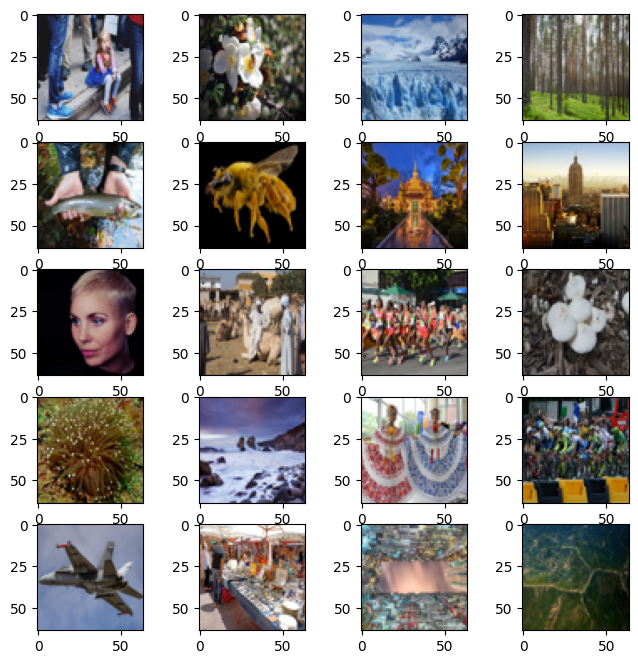

In [ ]:
# Show sample images from the training dataset
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()

In [ ]:

encoder_model, reveal_model1, autoencoder_model = make_model(input_train_S1.shape[1:])

dim (None, 64, 64, 3)
dim (None, 64, 64, 128)
here1
here2
here3
here4
here5
here6
here7
x3 :  (None, 64, 64, 128)
x :  (None, 64, 64, 224)
(None, 64, 64, 3)
(None, 64, 64, 3)
here


In [ ]:
# def lr_schedule(epoch_idx):
#     if epoch_idx < 200:
#         return 0.001
#     elif epoch_idx < 400:
#         return 0.0003
#     elif epoch_idx < 600:
#         return 0.0001
#     else:
#         return 0.00003

def lr_schedule(epoch_idx):
    return 0.0001

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
autoencoder_model.load_weights('/content/model450.h5')

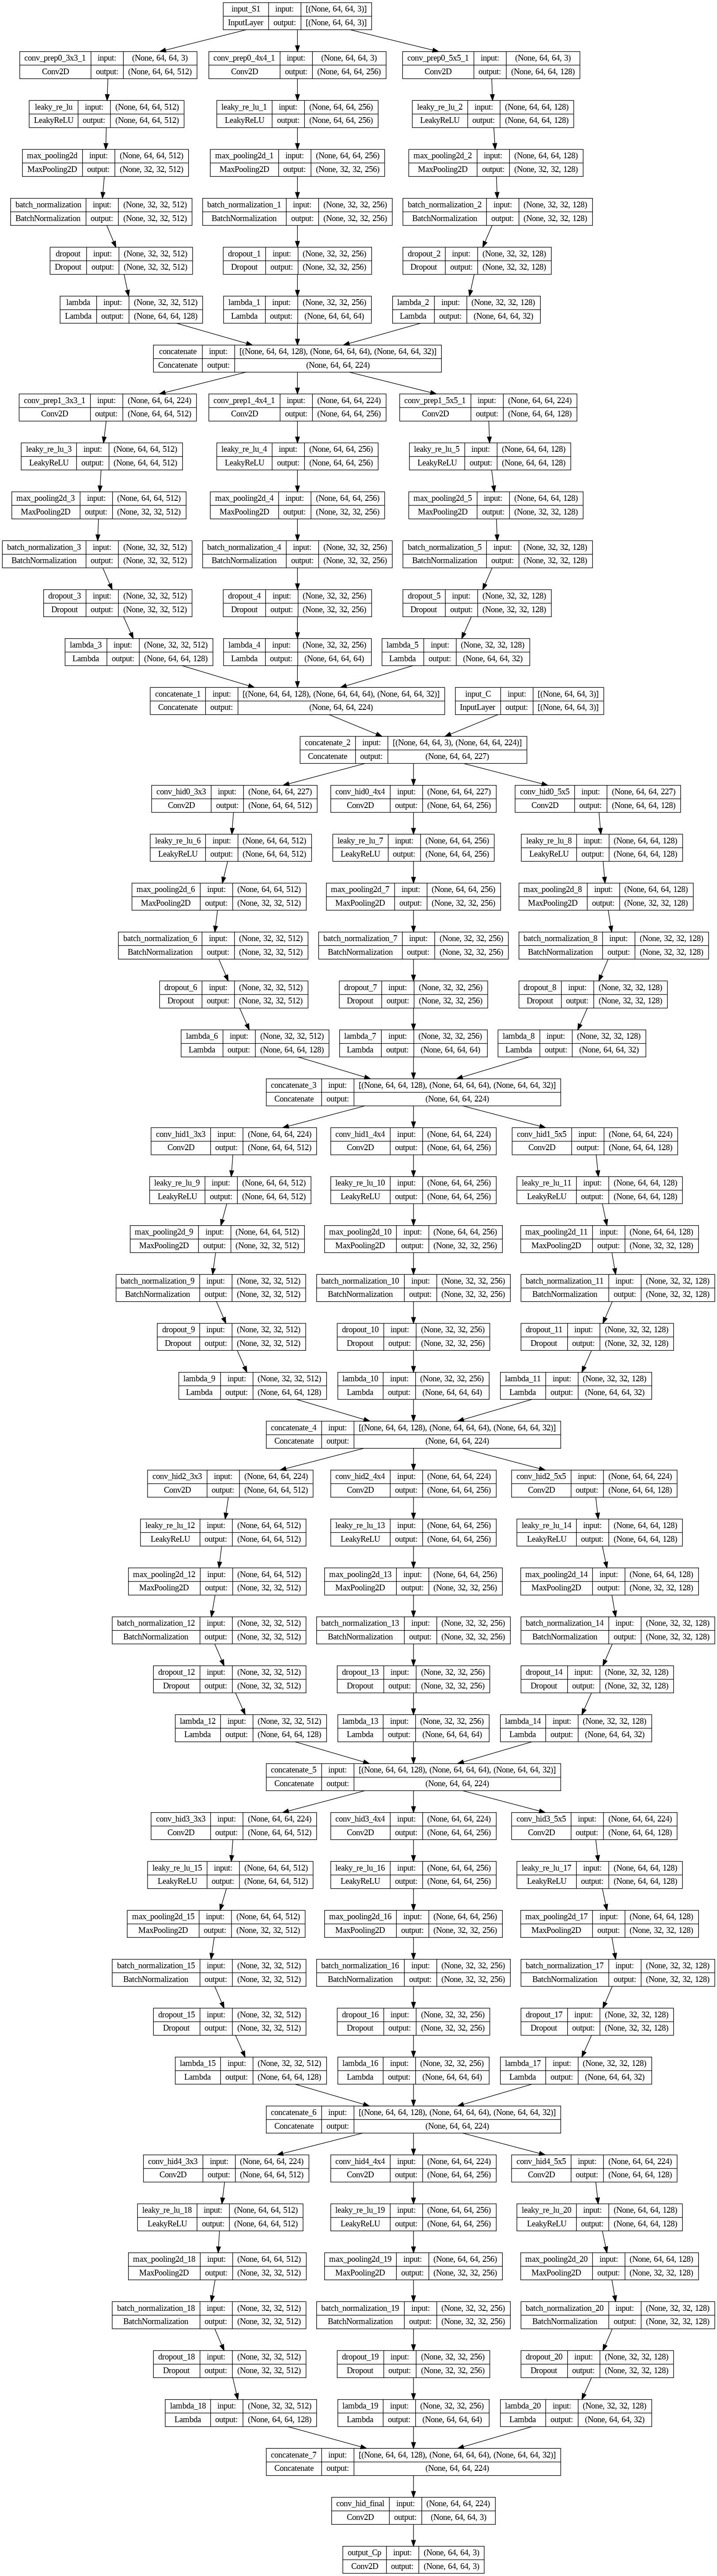

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(encoder_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

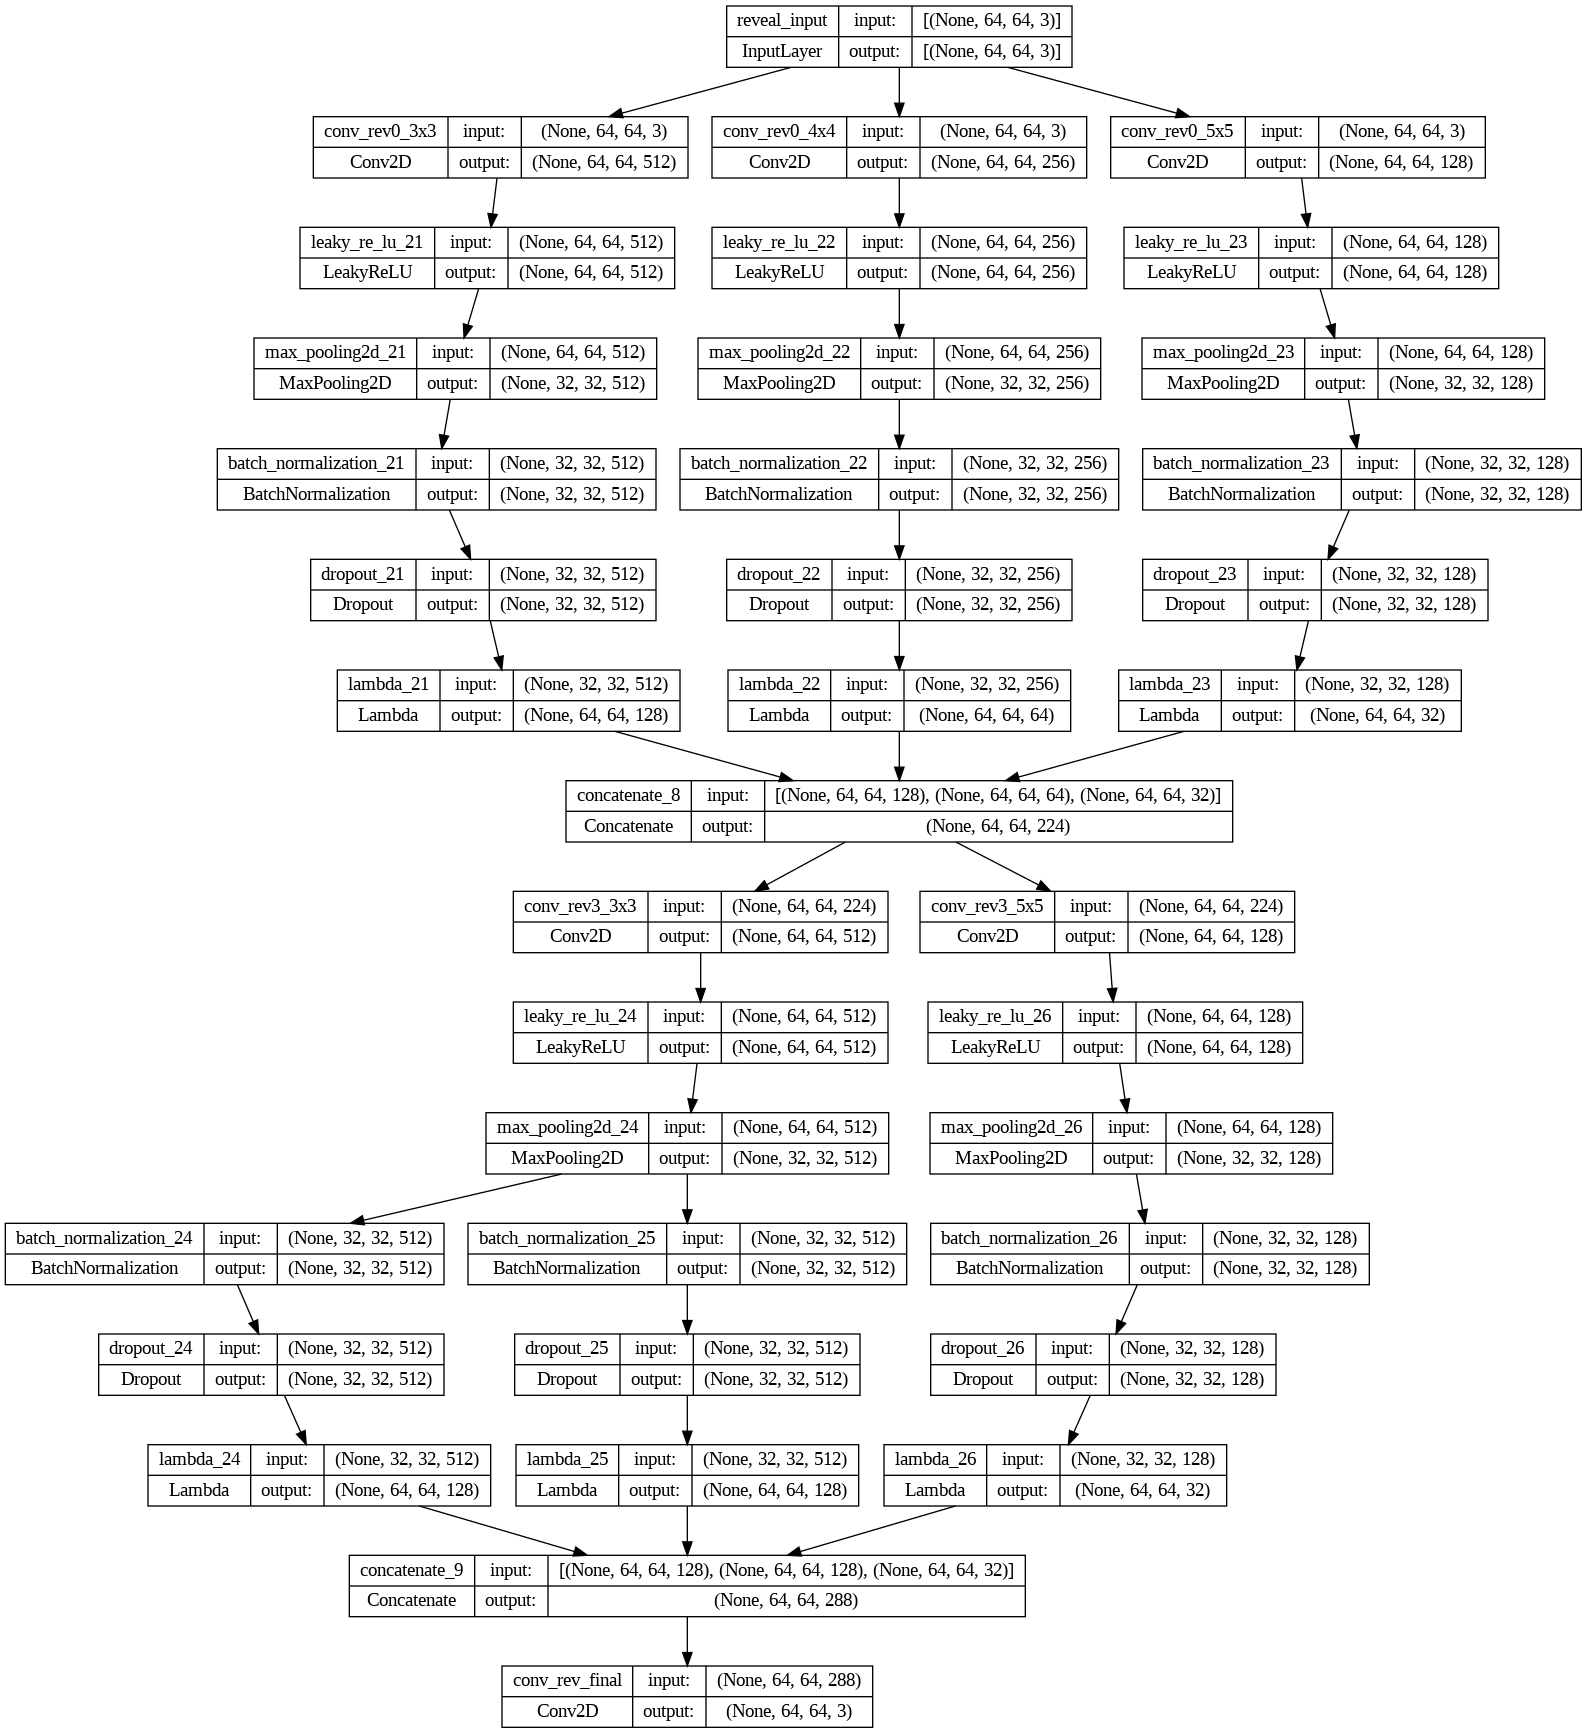

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(reveal_model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 519ms/step


Epoch 1 | Batch:   0 of 400. Loss AE -285505.00 | Loss Rev1  304530.50:   4%|▍         | 1/25 [00:35<14:17, 35.73s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch:  16 of 400. Loss AE  169219.94 | Loss Rev1  339816.19:   8%|▊         | 2/25 [00:37<06:07, 15.99s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 1 | Batch:  32 of 400. Loss AE  159694.65 | Loss Rev1  324990.16:  12%|█▏        | 3/25 [00:40<03:35,  9.79s/it]

1/1 [==============================] - 0s 36ms/step


Epoch 1 | Batch:  48 of 400. Loss AE   77941.69 | Loss Rev1  292088.00:  16%|█▌        | 4/25 [00:42<02:24,  6.89s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 1 | Batch:  64 of 400. Loss AE  206679.48 | Loss Rev1  272000.81:  20%|██        | 5/25 [00:44<01:43,  5.19s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 1 | Batch:  80 of 400. Loss AE  262758.17 | Loss Rev1  250484.60:  24%|██▍       | 6/25 [00:47<01:19,  4.17s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 1 | Batch:  96 of 400. Loss AE  298732.23 | Loss Rev1  227681.71:  28%|██▊       | 7/25 [00:49<01:03,  3.51s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 1 | Batch: 112 of 400. Loss AE  321281.38 | Loss Rev1  211521.48:  32%|███▏      | 8/25 [00:51<00:52,  3.08s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 1 | Batch: 128 of 400. Loss AE  333658.00 | Loss Rev1  195144.69:  36%|███▌      | 9/25 [00:53<00:46,  2.88s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 1 | Batch: 144 of 400. Loss AE  341046.56 | Loss Rev1  182930.28:  40%|████      | 10/25 [00:56<00:41,  2.75s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 1 | Batch: 160 of 400. Loss AE  344758.36 | Loss Rev1  169889.40:  44%|████▍     | 11/25 [00:59<00:40,  2.92s/it]

1/1 [==============================] - 0s 21ms/step


Epoch 1 | Batch: 176 of 400. Loss AE  321020.06 | Loss Rev1  159153.55:  48%|████▊     | 12/25 [01:01<00:35,  2.69s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 1 | Batch: 192 of 400. Loss AE  313667.99 | Loss Rev1  148955.39:  52%|█████▏    | 13/25 [01:04<00:30,  2.54s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 1 | Batch: 208 of 400. Loss AE  292967.46 | Loss Rev1  141643.77:  56%|█████▌    | 14/25 [01:06<00:26,  2.43s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 1 | Batch: 224 of 400. Loss AE  289002.30 | Loss Rev1  135197.33:  60%|██████    | 15/25 [01:08<00:24,  2.44s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 1 | Batch: 240 of 400. Loss AE  280328.56 | Loss Rev1  128963.41:  64%|██████▍   | 16/25 [01:11<00:24,  2.70s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 1 | Batch: 256 of 400. Loss AE  276243.56 | Loss Rev1  123007.25:  68%|██████▊   | 17/25 [01:14<00:20,  2.54s/it]

1/1 [==============================] - 0s 27ms/step


Epoch 1 | Batch: 272 of 400. Loss AE  269083.23 | Loss Rev1  118599.33:  72%|███████▏  | 18/25 [01:16<00:17,  2.43s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 1 | Batch: 288 of 400. Loss AE  264081.33 | Loss Rev1  114228.91:  76%|███████▌  | 19/25 [01:18<00:14,  2.35s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 1 | Batch: 304 of 400. Loss AE  246972.43 | Loss Rev1  109508.36:  80%|████████  | 20/25 [01:20<00:11,  2.29s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 1 | Batch: 320 of 400. Loss AE  240552.04 | Loss Rev1  105550.40:  84%|████████▍ | 21/25 [01:23<00:10,  2.58s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 336 of 400. Loss AE  234984.82 | Loss Rev1  101369.25:  88%|████████▊ | 22/25 [01:26<00:07,  2.45s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 1 | Batch: 352 of 400. Loss AE  227667.30 | Loss Rev1   97835.92:  92%|█████████▏| 23/25 [01:28<00:04,  2.36s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 1 | Batch: 368 of 400. Loss AE  214804.79 | Loss Rev1   94288.71:  96%|█████████▌| 24/25 [01:30<00:02,  2.29s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 384 of 400. Loss AE  209190.83 | Loss Rev1   90883.11: 100%|██████████| 25/25 [01:32<00:00,  3.70s/it]


1/1 [==============================] - 1s 763ms/step - loss: 505860.7500



 33%|███▎      | 1/3 [01:35<03:11, 95.64s/it]

1/1 [==============================] - 0s 105ms/step - loss: 476478.0625



 67%|██████▋   | 2/3 [01:36<00:39, 39.98s/it]

1/1 [==============================] - 0s 104ms/step - loss: 471404.7812



100%|██████████| 3/3 [01:37<00:00, 32.54s/it]

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 1s 1s/step


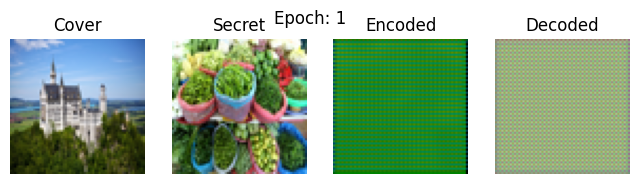

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 2 | Batch:   0 of 400. Loss AE   88136.55 | Loss Rev1   13412.47:   4%|▍         | 1/25 [00:02<00:51,  2.14s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch:  16 of 400. Loss AE   86314.22 | Loss Rev1   16921.93:   8%|▊         | 2/25 [00:04<00:48,  2.13s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch:  32 of 400. Loss AE   70872.29 | Loss Rev1   17017.89:  12%|█▏        | 3/25 [00:06<00:46,  2.13s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch:  48 of 400. Loss AE    9631.13 | Loss Rev1   16713.76:  16%|█▌        | 4/25 [00:08<00:47,  2.25s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 2 | Batch:  64 of 400. Loss AE   17503.14 | Loss Rev1   16018.94:  20%|██        | 5/25 [00:10<00:44,  2.22s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 2 | Batch:  80 of 400. Loss AE   15141.25 | Loss Rev1   15592.09:  24%|██▍       | 6/25 [00:14<00:48,  2.57s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch:  96 of 400. Loss AE   19726.27 | Loss Rev1   14825.13:  28%|██▊       | 7/25 [00:16<00:43,  2.43s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch: 112 of 400. Loss AE   24209.48 | Loss Rev1   14852.11:  32%|███▏      | 8/25 [00:18<00:39,  2.33s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch: 128 of 400. Loss AE   26818.17 | Loss Rev1   13915.81:  36%|███▌      | 9/25 [00:21<00:41,  2.62s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 144 of 400. Loss AE   29839.70 | Loss Rev1   13073.09:  40%|████      | 10/25 [00:23<00:37,  2.47s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch: 160 of 400. Loss AE   28618.88 | Loss Rev1   12147.55:  44%|████▍     | 11/25 [00:26<00:33,  2.37s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 176 of 400. Loss AE   28870.81 | Loss Rev1   11469.36:  48%|████▊     | 12/25 [00:28<00:30,  2.31s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch: 192 of 400. Loss AE   24865.83 | Loss Rev1   10833.46:  52%|█████▏    | 13/25 [00:30<00:27,  2.26s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch: 208 of 400. Loss AE   23299.50 | Loss Rev1   10449.90:  56%|█████▌    | 14/25 [00:33<00:28,  2.57s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 2 | Batch: 224 of 400. Loss AE   14610.67 | Loss Rev1   10180.82:  60%|██████    | 15/25 [00:35<00:24,  2.44s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch: 240 of 400. Loss AE    9171.72 | Loss Rev1    9948.46:  64%|██████▍   | 16/25 [00:37<00:21,  2.36s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 256 of 400. Loss AE   10906.90 | Loss Rev1    9535.70:  68%|██████▊   | 17/25 [00:40<00:18,  2.30s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 272 of 400. Loss AE    1360.97 | Loss Rev1    9245.31:  72%|███████▏  | 18/25 [00:42<00:15,  2.25s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch: 288 of 400. Loss AE    3394.77 | Loss Rev1    9099.62:  76%|███████▌  | 19/25 [00:44<00:13,  2.31s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 2 | Batch: 304 of 400. Loss AE    4385.90 | Loss Rev1    8729.43:  80%|████████  | 20/25 [00:46<00:11,  2.28s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 320 of 400. Loss AE    5474.12 | Loss Rev1    8930.74:  84%|████████▍ | 21/25 [00:49<00:08,  2.25s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 336 of 400. Loss AE    3033.86 | Loss Rev1    8663.94:  88%|████████▊ | 22/25 [00:51<00:06,  2.22s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 352 of 400. Loss AE    2550.79 | Loss Rev1    8557.59:  92%|█████████▏| 23/25 [00:53<00:04,  2.20s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 368 of 400. Loss AE    1930.95 | Loss Rev1    8434.96:  96%|█████████▌| 24/25 [00:55<00:02,  2.18s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 384 of 400. Loss AE   -4536.65 | Loss Rev1    8465.92: 100%|██████████| 25/25 [00:57<00:00,  2.32s/it]


1/1 [==============================] - 0s 105ms/step - loss: 348788.0000



 33%|███▎      | 1/3 [00:59<01:58, 59.20s/it]

1/1 [==============================] - 0s 105ms/step - loss: 342065.6875



 67%|██████▋   | 2/3 [01:00<00:25, 25.12s/it]

1/1 [==============================] - 0s 103ms/step - loss: 313164.8125



100%|██████████| 3/3 [01:01<00:00, 20.56s/it]

1/1 [==============================] - 0s 22ms/step


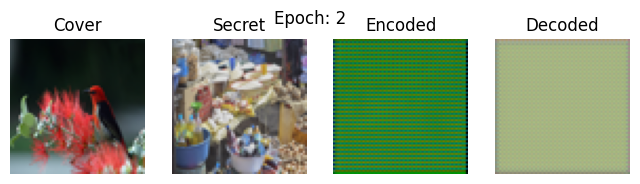

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch:   0 of 400. Loss AE -173069.88 | Loss Rev1    2836.73:   4%|▍         | 1/25 [00:03<01:18,  3.27s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch:  16 of 400. Loss AE  -88083.96 | Loss Rev1    3572.42:   8%|▊         | 2/25 [00:05<00:59,  2.61s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch:  32 of 400. Loss AE  -55756.04 | Loss Rev1    3459.79:  12%|█▏        | 3/25 [00:08<01:03,  2.90s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch:  48 of 400. Loss AE  -45013.84 | Loss Rev1    3017.18:  16%|█▌        | 4/25 [00:10<00:54,  2.60s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch:  64 of 400. Loss AE  -68465.90 | Loss Rev1    3314.77:  20%|██        | 5/25 [00:12<00:48,  2.44s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch:  80 of 400. Loss AE  -63998.64 | Loss Rev1    4067.11:  24%|██▍       | 6/25 [00:15<00:44,  2.33s/it]

1/1 [==============================] - 0s 26ms/step


Epoch 3 | Batch:  96 of 400. Loss AE  -58484.28 | Loss Rev1    4330.63:  28%|██▊       | 7/25 [00:17<00:40,  2.27s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch: 112 of 400. Loss AE  -58927.98 | Loss Rev1    4101.39:  32%|███▏      | 8/25 [00:19<00:39,  2.32s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 3 | Batch: 128 of 400. Loss AE  -80646.06 | Loss Rev1    4779.76:  36%|███▌      | 9/25 [00:21<00:36,  2.28s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch: 144 of 400. Loss AE  -76554.74 | Loss Rev1    6628.46:  40%|████      | 10/25 [00:23<00:33,  2.24s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch: 160 of 400. Loss AE  -79622.58 | Loss Rev1    6423.98:  44%|████▍     | 11/25 [00:26<00:30,  2.21s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch: 176 of 400. Loss AE  -77866.77 | Loss Rev1    6680.12:  48%|████▊     | 12/25 [00:29<00:32,  2.53s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch: 192 of 400. Loss AE  -74549.43 | Loss Rev1    6749.34:  52%|█████▏    | 13/25 [00:31<00:29,  2.42s/it]

1/1 [==============================] - 0s 40ms/step


Epoch 3 | Batch: 208 of 400. Loss AE  -71140.96 | Loss Rev1    6572.30:  56%|█████▌    | 14/25 [00:34<00:29,  2.68s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch: 224 of 400. Loss AE  -67561.19 | Loss Rev1    6379.27:  60%|██████    | 15/25 [00:36<00:25,  2.51s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch: 240 of 400. Loss AE  -67242.95 | Loss Rev1    6223.52:  64%|██████▍   | 16/25 [00:39<00:21,  2.40s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch: 256 of 400. Loss AE  -67678.92 | Loss Rev1    6258.25:  68%|██████▊   | 17/25 [00:41<00:18,  2.33s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch: 272 of 400. Loss AE  -67941.26 | Loss Rev1    6540.43:  72%|███████▏  | 18/25 [00:43<00:15,  2.27s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch: 288 of 400. Loss AE  -68426.91 | Loss Rev1    6287.23:  76%|███████▌  | 19/25 [00:46<00:15,  2.57s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch: 304 of 400. Loss AE  -70300.15 | Loss Rev1    6291.24:  80%|████████  | 20/25 [00:48<00:12,  2.45s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch: 320 of 400. Loss AE  -69752.91 | Loss Rev1    6185.51:  84%|████████▍ | 21/25 [00:50<00:09,  2.36s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch: 336 of 400. Loss AE  -69257.30 | Loss Rev1    6028.77:  88%|████████▊ | 22/25 [00:53<00:06,  2.30s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch: 352 of 400. Loss AE  -68615.22 | Loss Rev1    6017.75:  92%|█████████▏| 23/25 [00:55<00:04,  2.25s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch: 368 of 400. Loss AE  -72934.93 | Loss Rev1    6114.03:  96%|█████████▌| 24/25 [00:58<00:02,  2.56s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch: 384 of 400. Loss AE  -81346.32 | Loss Rev1    6125.20: 100%|██████████| 25/25 [01:00<00:00,  2.43s/it]


1/1 [==============================] - 0s 106ms/step - loss: 225200.7500



 33%|███▎      | 1/3 [01:01<02:03, 61.92s/it]

1/1 [==============================] - 0s 105ms/step - loss: 231883.7656



 67%|██████▋   | 2/3 [01:02<00:26, 26.07s/it]

1/1 [==============================] - 0s 103ms/step - loss: 217758.7188



100%|██████████| 3/3 [01:03<00:00, 21.29s/it]

1/1 [==============================] - 0s 22ms/step


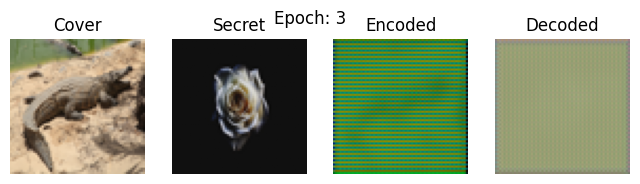

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch:   0 of 400. Loss AE -101650.17 | Loss Rev1    2987.39:   4%|▍         | 1/25 [00:02<00:52,  2.17s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch:  16 of 400. Loss AE -159736.80 | Loss Rev1    3676.79:   8%|▊         | 2/25 [00:05<01:04,  2.82s/it]

1/1 [==============================] - 0s 38ms/step


Epoch 4 | Batch:  32 of 400. Loss AE -191399.17 | Loss Rev1    4005.79:  12%|█▏        | 3/25 [00:07<00:55,  2.53s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch:  48 of 400. Loss AE -154422.92 | Loss Rev1    6012.40:  16%|█▌        | 4/25 [00:09<00:49,  2.37s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch:  64 of 400. Loss AE -134351.15 | Loss Rev1    6090.08:  20%|██        | 5/25 [00:11<00:45,  2.29s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch:  80 of 400. Loss AE -119767.72 | Loss Rev1    5746.36:  24%|██▍       | 6/25 [00:14<00:42,  2.24s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch:  96 of 400. Loss AE -114150.24 | Loss Rev1    5511.85:  28%|██▊       | 7/25 [00:17<00:48,  2.67s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 112 of 400. Loss AE -106852.90 | Loss Rev1    5439.03:  32%|███▏      | 8/25 [00:19<00:42,  2.50s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 128 of 400. Loss AE -106606.30 | Loss Rev1    5707.60:  36%|███▌      | 9/25 [00:21<00:38,  2.39s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 144 of 400. Loss AE -102003.60 | Loss Rev1    5611.09:  40%|████      | 10/25 [00:24<00:34,  2.31s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 160 of 400. Loss AE -101716.30 | Loss Rev1    5356.03:  44%|████▍     | 11/25 [00:26<00:31,  2.26s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch: 176 of 400. Loss AE -109820.70 | Loss Rev1    5425.61:  48%|████▊     | 12/25 [00:29<00:33,  2.57s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch: 192 of 400. Loss AE -108719.18 | Loss Rev1    5166.96:  52%|█████▏    | 13/25 [00:31<00:29,  2.44s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch: 208 of 400. Loss AE -104647.12 | Loss Rev1    4887.72:  56%|█████▌    | 14/25 [00:33<00:25,  2.35s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 4 | Batch: 224 of 400. Loss AE -102833.93 | Loss Rev1    4745.02:  60%|██████    | 15/25 [00:35<00:22,  2.29s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch: 240 of 400. Loss AE -103084.12 | Loss Rev1    4627.44:  64%|██████▍   | 16/25 [00:38<00:21,  2.34s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch: 256 of 400. Loss AE -103832.50 | Loss Rev1    4496.96:  68%|██████▊   | 17/25 [00:40<00:18,  2.37s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 4 | Batch: 272 of 400. Loss AE -103797.63 | Loss Rev1    4475.92:  72%|███████▏  | 18/25 [00:42<00:16,  2.32s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 288 of 400. Loss AE -104087.61 | Loss Rev1    4595.28:  76%|███████▌  | 19/25 [00:45<00:13,  2.27s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch: 304 of 400. Loss AE -104207.07 | Loss Rev1    4833.66:  80%|████████  | 20/25 [00:47<00:11,  2.23s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch: 320 of 400. Loss AE -117019.73 | Loss Rev1    4776.88:  84%|████████▍ | 21/25 [00:49<00:08,  2.21s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 336 of 400. Loss AE -119659.14 | Loss Rev1    5003.27:  88%|████████▊ | 22/25 [00:51<00:06,  2.19s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 352 of 400. Loss AE -119675.03 | Loss Rev1    4919.72:  92%|█████████▏| 23/25 [00:54<00:05,  2.52s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 368 of 400. Loss AE -119313.61 | Loss Rev1    4847.29:  96%|█████████▌| 24/25 [00:57<00:02,  2.41s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 4 | Batch: 384 of 400. Loss AE -119452.63 | Loss Rev1    5071.14: 100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


1/1 [==============================] - 0s 103ms/step - loss: 143133.2188



 33%|███▎      | 1/3 [01:00<02:00, 60.16s/it]

1/1 [==============================] - 0s 104ms/step - loss: 123018.5000



 67%|██████▋   | 2/3 [01:01<00:25, 25.51s/it]

1/1 [==============================] - 0s 104ms/step - loss: 126475.8281



100%|██████████| 3/3 [01:02<00:00, 20.88s/it]

1/1 [==============================] - 0s 23ms/step


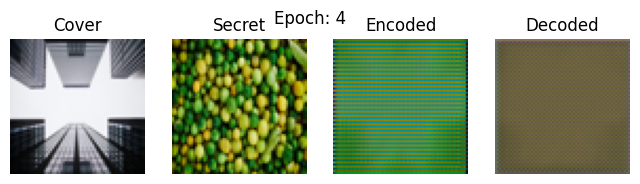

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch:   0 of 400. Loss AE -131713.77 | Loss Rev1    4516.06:   4%|▍         | 1/25 [00:02<00:52,  2.18s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 5 | Batch:  16 of 400. Loss AE -126177.68 | Loss Rev1    3424.36:   8%|▊         | 2/25 [00:04<00:50,  2.18s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch:  32 of 400. Loss AE -129724.94 | Loss Rev1    4196.74:  12%|█▏        | 3/25 [00:06<00:47,  2.17s/it]

1/1 [==============================] - 0s 30ms/step


Epoch 5 | Batch:  48 of 400. Loss AE -124719.19 | Loss Rev1    4452.91:  16%|█▌        | 4/25 [00:08<00:45,  2.17s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch:  64 of 400. Loss AE -160832.00 | Loss Rev1    4883.32:  20%|██        | 5/25 [00:10<00:43,  2.16s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch:  80 of 400. Loss AE -180826.88 | Loss Rev1    4725.22:  24%|██▍       | 6/25 [00:12<00:40,  2.16s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch:  96 of 400. Loss AE -174391.12 | Loss Rev1    6765.82:  28%|██▊       | 7/25 [00:16<00:45,  2.52s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch: 112 of 400. Loss AE -169660.61 | Loss Rev1    6082.62:  32%|███▏      | 8/25 [00:18<00:40,  2.39s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch: 128 of 400. Loss AE -190807.13 | Loss Rev1    5862.72:  36%|███▌      | 9/25 [00:20<00:37,  2.31s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch: 144 of 400. Loss AE -185142.07 | Loss Rev1    5564.40:  40%|████      | 10/25 [00:22<00:33,  2.26s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 160 of 400. Loss AE -182332.99 | Loss Rev1    5482.40:  44%|████▍     | 11/25 [00:24<00:31,  2.23s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 176 of 400. Loss AE -179266.68 | Loss Rev1    5561.04:  48%|████▊     | 12/25 [00:28<00:33,  2.54s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 192 of 400. Loss AE -177042.76 | Loss Rev1    5528.74:  52%|█████▏    | 13/25 [00:30<00:29,  2.42s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 5 | Batch: 208 of 400. Loss AE -176848.65 | Loss Rev1    6079.56:  56%|█████▌    | 14/25 [00:32<00:25,  2.34s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 5 | Batch: 224 of 400. Loss AE -173843.43 | Loss Rev1    5980.27:  60%|██████    | 15/25 [00:34<00:22,  2.29s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch: 240 of 400. Loss AE -172624.71 | Loss Rev1    5871.75:  64%|██████▍   | 16/25 [00:36<00:20,  2.24s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 5 | Batch: 256 of 400. Loss AE -172077.31 | Loss Rev1    5993.39:  68%|██████▊   | 17/25 [00:39<00:20,  2.55s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch: 272 of 400. Loss AE -177824.88 | Loss Rev1    6102.82:  72%|███████▏  | 18/25 [00:42<00:17,  2.43s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 288 of 400. Loss AE -174453.27 | Loss Rev1    5962.49:  76%|███████▌  | 19/25 [00:44<00:14,  2.35s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch: 304 of 400. Loss AE -173152.09 | Loss Rev1    6057.58:  80%|████████  | 20/25 [00:46<00:11,  2.29s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 320 of 400. Loss AE -171812.63 | Loss Rev1    6227.30:  84%|████████▍ | 21/25 [00:48<00:09,  2.25s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 5 | Batch: 336 of 400. Loss AE -170935.27 | Loss Rev1    6401.47:  88%|████████▊ | 22/25 [00:51<00:07,  2.56s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 352 of 400. Loss AE -170927.95 | Loss Rev1    6453.64:  92%|█████████▏| 23/25 [00:53<00:04,  2.43s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch: 368 of 400. Loss AE -174601.97 | Loss Rev1    6607.47:  96%|█████████▌| 24/25 [00:56<00:02,  2.34s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 384 of 400. Loss AE -170915.05 | Loss Rev1    6470.41: 100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


1/1 [==============================] - 0s 103ms/step - loss: 218714.7344



 33%|███▎      | 1/3 [00:59<01:58, 59.22s/it]

1/1 [==============================] - 0s 106ms/step - loss: 209320.3438



 67%|██████▋   | 2/3 [01:00<00:25, 25.10s/it]

1/1 [==============================] - 0s 110ms/step - loss: 214463.5000



100%|██████████| 3/3 [01:01<00:00, 20.57s/it]

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 43ms/step


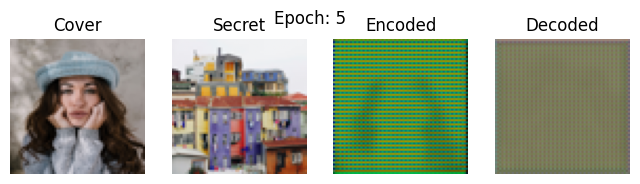

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 6 | Batch:   0 of 400. Loss AE  -96579.27 | Loss Rev1    9186.04:   4%|▍         | 1/25 [00:03<01:19,  3.31s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 6 | Batch:  16 of 400. Loss AE  -91366.11 | Loss Rev1    7049.65:   8%|▊         | 2/25 [00:05<01:00,  2.63s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 6 | Batch:  32 of 400. Loss AE -104584.37 | Loss Rev1    9171.96:  12%|█▏        | 3/25 [00:07<00:53,  2.41s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 6 | Batch:  48 of 400. Loss AE -106481.92 | Loss Rev1    9760.42:  16%|█▌        | 4/25 [00:09<00:48,  2.31s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 6 | Batch:  64 of 400. Loss AE -109936.26 | Loss Rev1    9090.11:  20%|██        | 5/25 [00:11<00:45,  2.26s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 6 | Batch:  80 of 400. Loss AE -114586.18 | Loss Rev1    8690.02:  24%|██▍       | 6/25 [00:15<00:49,  2.60s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 6 | Batch:  96 of 400. Loss AE -112365.71 | Loss Rev1    8348.74:  28%|██▊       | 7/25 [00:17<00:44,  2.45s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 6 | Batch: 112 of 400. Loss AE -113231.83 | Loss Rev1    7837.62:  32%|███▏      | 8/25 [00:19<00:40,  2.35s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 6 | Batch: 128 of 400. Loss AE -126323.38 | Loss Rev1    7452.46:  36%|███▌      | 9/25 [00:21<00:36,  2.30s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 6 | Batch: 144 of 400. Loss AE -124001.75 | Loss Rev1    7492.51:  40%|████      | 10/25 [00:23<00:33,  2.25s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 6 | Batch: 160 of 400. Loss AE -122016.07 | Loss Rev1    7457.96:  44%|████▍     | 11/25 [00:27<00:35,  2.56s/it]

1/1 [==============================] - 0s 26ms/step


Epoch 6 | Batch: 176 of 400. Loss AE -119318.12 | Loss Rev1    8145.72:  48%|████▊     | 12/25 [00:29<00:31,  2.44s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 192 of 400. Loss AE -115965.92 | Loss Rev1    7996.82:  52%|█████▏    | 13/25 [00:31<00:28,  2.36s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 6 | Batch: 208 of 400. Loss AE -116795.55 | Loss Rev1    8480.27:  56%|█████▌    | 14/25 [00:33<00:25,  2.29s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 6 | Batch: 224 of 400. Loss AE -115296.51 | Loss Rev1    8678.01:  60%|██████    | 15/25 [00:35<00:22,  2.25s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 6 | Batch: 240 of 400. Loss AE -113289.28 | Loss Rev1    8370.81:  64%|██████▍   | 16/25 [00:38<00:22,  2.55s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 256 of 400. Loss AE -112938.91 | Loss Rev1    8413.87:  68%|██████▊   | 17/25 [00:41<00:19,  2.43s/it]

1/1 [==============================] - 0s 28ms/step


Epoch 6 | Batch: 272 of 400. Loss AE -122792.45 | Loss Rev1    8589.30:  72%|███████▏  | 18/25 [00:43<00:16,  2.34s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 288 of 400. Loss AE -123878.05 | Loss Rev1    8365.65:  76%|███████▌  | 19/25 [00:45<00:13,  2.29s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 6 | Batch: 304 of 400. Loss AE -129796.28 | Loss Rev1    8591.67:  80%|████████  | 20/25 [00:47<00:11,  2.24s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 6 | Batch: 320 of 400. Loss AE -137310.44 | Loss Rev1    8420.78:  84%|████████▍ | 21/25 [00:49<00:09,  2.31s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 6 | Batch: 336 of 400. Loss AE -135714.89 | Loss Rev1    8150.42:  88%|████████▊ | 22/25 [00:53<00:07,  2.60s/it]

1/1 [==============================] - 0s 26ms/step


Epoch 6 | Batch: 352 of 400. Loss AE -135537.33 | Loss Rev1    8015.53:  92%|█████████▏| 23/25 [00:55<00:04,  2.47s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 6 | Batch: 368 of 400. Loss AE -143535.78 | Loss Rev1    7787.27:  96%|█████████▌| 24/25 [00:57<00:02,  2.38s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 6 | Batch: 384 of 400. Loss AE -143937.71 | Loss Rev1    7721.31: 100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


1/1 [==============================] - 0s 105ms/step - loss: 121901.1797



 33%|███▎      | 1/3 [01:00<02:01, 60.72s/it]

1/1 [==============================] - 0s 114ms/step - loss: 93408.0000



 67%|██████▋   | 2/3 [01:02<00:25, 25.76s/it]

1/1 [==============================] - 0s 117ms/step - loss: 92378.6562



100%|██████████| 3/3 [01:03<00:00, 21.11s/it]

1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 34ms/step


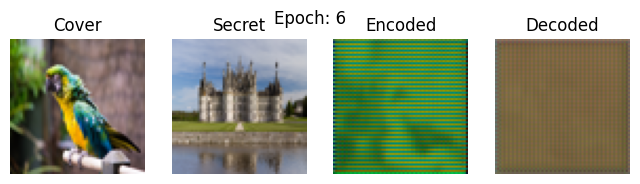

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 7 | Batch:   0 of 400. Loss AE -176397.81 | Loss Rev1    1922.45:   4%|▍         | 1/25 [00:02<00:52,  2.17s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 7 | Batch:  16 of 400. Loss AE -182530.39 | Loss Rev1    1922.21:   8%|▊         | 2/25 [00:04<00:49,  2.17s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 7 | Batch:  32 of 400. Loss AE -177699.20 | Loss Rev1    2730.57:  12%|█▏        | 3/25 [00:06<00:47,  2.16s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 7 | Batch:  48 of 400. Loss AE -176175.90 | Loss Rev1    3107.39:  16%|█▌        | 4/25 [00:08<00:45,  2.16s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 7 | Batch:  64 of 400. Loss AE -181564.42 | Loss Rev1    3100.93:  20%|██        | 5/25 [00:11<00:51,  2.56s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 7 | Batch:  80 of 400. Loss AE -186790.11 | Loss Rev1    3916.19:  24%|██▍       | 6/25 [00:14<00:45,  2.42s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 7 | Batch:  96 of 400. Loss AE -185538.71 | Loss Rev1    4791.01:  28%|██▊       | 7/25 [00:16<00:42,  2.34s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 7 | Batch: 112 of 400. Loss AE -186211.91 | Loss Rev1    5292.52:  32%|███▏      | 8/25 [00:18<00:38,  2.28s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 7 | Batch: 128 of 400. Loss AE -187858.74 | Loss Rev1    5805.82:  36%|███▌      | 9/25 [00:20<00:35,  2.24s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 7 | Batch: 144 of 400. Loss AE -190875.94 | Loss Rev1    5597.44:  40%|████      | 10/25 [00:23<00:38,  2.56s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 7 | Batch: 160 of 400. Loss AE -194359.17 | Loss Rev1    5514.49:  44%|████▍     | 11/25 [00:25<00:34,  2.44s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 7 | Batch: 176 of 400. Loss AE -196508.45 | Loss Rev1    5576.40:  48%|████▊     | 12/25 [00:28<00:30,  2.35s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 7 | Batch: 192 of 400. Loss AE -199654.57 | Loss Rev1    5503.68:  52%|█████▏    | 13/25 [00:30<00:27,  2.29s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 7 | Batch: 208 of 400. Loss AE -203298.82 | Loss Rev1    5440.24:  56%|█████▌    | 14/25 [00:32<00:24,  2.25s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 7 | Batch: 224 of 400. Loss AE -215445.41 | Loss Rev1    5355.72:  60%|██████    | 15/25 [00:35<00:26,  2.65s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 7 | Batch: 240 of 400. Loss AE -213633.27 | Loss Rev1    6204.09:  64%|██████▍   | 16/25 [00:38<00:22,  2.50s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 7 | Batch: 256 of 400. Loss AE -214135.92 | Loss Rev1    6407.13:  68%|██████▊   | 17/25 [00:40<00:19,  2.40s/it]

1/1 [==============================] - 0s 27ms/step


Epoch 7 | Batch: 272 of 400. Loss AE -217276.21 | Loss Rev1    6493.15:  72%|███████▏  | 18/25 [00:42<00:16,  2.32s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 7 | Batch: 288 of 400. Loss AE -231069.76 | Loss Rev1    6639.07:  76%|███████▌  | 19/25 [00:44<00:13,  2.27s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 7 | Batch: 304 of 400. Loss AE -233391.26 | Loss Rev1    6541.07:  80%|████████  | 20/25 [00:47<00:12,  2.57s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 7 | Batch: 320 of 400. Loss AE -242169.91 | Loss Rev1    6564.97:  84%|████████▍ | 21/25 [00:50<00:09,  2.45s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 7 | Batch: 336 of 400. Loss AE -242560.78 | Loss Rev1    6743.55:  88%|████████▊ | 22/25 [00:52<00:07,  2.36s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 7 | Batch: 352 of 400. Loss AE -242557.52 | Loss Rev1    6742.85:  92%|█████████▏| 23/25 [00:54<00:04,  2.30s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 7 | Batch: 368 of 400. Loss AE -242450.88 | Loss Rev1    6874.66:  96%|█████████▌| 24/25 [00:56<00:02,  2.25s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 7 | Batch: 384 of 400. Loss AE -248263.77 | Loss Rev1    6800.71: 100%|██████████| 25/25 [00:58<00:00,  2.36s/it]


1/1 [==============================] - 0s 123ms/step - loss: 241473.5000



 33%|███▎      | 1/3 [01:00<02:00, 60.31s/it]

1/1 [==============================] - 0s 108ms/step - loss: 223912.0469



 67%|██████▋   | 2/3 [01:01<00:25, 25.55s/it]

1/1 [==============================] - 0s 104ms/step - loss: 230965.4531



100%|██████████| 3/3 [01:02<00:00, 20.92s/it]

1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


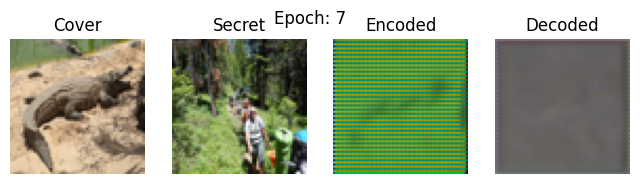

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 8 | Batch:   0 of 400. Loss AE -202005.81 | Loss Rev1   13024.78:   4%|▍         | 1/25 [00:02<00:52,  2.17s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch:  16 of 400. Loss AE -226339.45 | Loss Rev1   13515.28:   8%|▊         | 2/25 [00:04<00:49,  2.16s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 8 | Batch:  32 of 400. Loss AE -233558.22 | Loss Rev1   11782.80:  12%|█▏        | 3/25 [00:06<00:50,  2.29s/it]

1/1 [==============================] - 0s 21ms/step


Epoch 8 | Batch:  48 of 400. Loss AE -239661.28 | Loss Rev1   10807.01:  16%|█▌        | 4/25 [00:10<00:56,  2.68s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch:  64 of 400. Loss AE -237926.17 | Loss Rev1    9852.40:  20%|██        | 5/25 [00:12<00:49,  2.50s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch:  80 of 400. Loss AE -232941.23 | Loss Rev1    8704.93:  24%|██▍       | 6/25 [00:14<00:45,  2.38s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch:  96 of 400. Loss AE -232247.73 | Loss Rev1    7920.32:  28%|██▊       | 7/25 [00:16<00:41,  2.31s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 112 of 400. Loss AE -234665.41 | Loss Rev1    7335.33:  32%|███▏      | 8/25 [00:18<00:38,  2.26s/it]

1/1 [==============================] - 0s 29ms/step


Epoch 8 | Batch: 128 of 400. Loss AE -260378.47 | Loss Rev1    6803.03:  36%|███▌      | 9/25 [00:20<00:35,  2.23s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 8 | Batch: 144 of 400. Loss AE -188928.03 | Loss Rev1    6539.14:  40%|████      | 10/25 [00:23<00:33,  2.22s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch: 160 of 400. Loss AE -200966.11 | Loss Rev1    6266.77:  44%|████▍     | 11/25 [00:25<00:30,  2.20s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 176 of 400. Loss AE -209327.29 | Loss Rev1    6185.23:  48%|████▊     | 12/25 [00:27<00:28,  2.19s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 192 of 400. Loss AE -227877.25 | Loss Rev1    6045.98:  52%|█████▏    | 13/25 [00:29<00:26,  2.18s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 8 | Batch: 208 of 400. Loss AE -233852.92 | Loss Rev1    5845.32:  56%|█████▌    | 14/25 [00:31<00:23,  2.18s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 8 | Batch: 224 of 400. Loss AE -238380.82 | Loss Rev1    6072.25:  60%|██████    | 15/25 [00:35<00:25,  2.52s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 8 | Batch: 240 of 400. Loss AE -247513.89 | Loss Rev1    6200.84:  64%|██████▍   | 16/25 [00:37<00:21,  2.41s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 256 of 400. Loss AE -252690.22 | Loss Rev1    6018.67:  68%|██████▊   | 17/25 [00:39<00:18,  2.33s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 8 | Batch: 272 of 400. Loss AE -255215.69 | Loss Rev1    5804.83:  72%|███████▏  | 18/25 [00:41<00:15,  2.28s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 8 | Batch: 288 of 400. Loss AE -258432.11 | Loss Rev1    6028.80:  76%|███████▌  | 19/25 [00:43<00:13,  2.24s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 8 | Batch: 304 of 400. Loss AE -262376.49 | Loss Rev1    6232.61:  80%|████████  | 20/25 [00:46<00:12,  2.55s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 320 of 400. Loss AE -268218.63 | Loss Rev1    6011.34:  84%|████████▍ | 21/25 [00:49<00:09,  2.43s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 8 | Batch: 336 of 400. Loss AE -272738.65 | Loss Rev1    5825.77:  88%|████████▊ | 22/25 [00:51<00:07,  2.34s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 352 of 400. Loss AE -277024.53 | Loss Rev1    5696.00:  92%|█████████▏| 23/25 [00:53<00:04,  2.29s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 368 of 400. Loss AE -281592.30 | Loss Rev1    5638.53:  96%|█████████▌| 24/25 [00:55<00:02,  2.25s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch: 384 of 400. Loss AE -285384.83 | Loss Rev1    5571.47: 100%|██████████| 25/25 [00:58<00:00,  2.35s/it]


1/1 [==============================] - 0s 107ms/step - loss: 216684.6250



 33%|███▎      | 1/3 [01:00<02:00, 60.02s/it]

1/1 [==============================] - 0s 105ms/step - loss: 226743.1250



 67%|██████▋   | 2/3 [01:01<00:25, 25.31s/it]

1/1 [==============================] - 0s 115ms/step - loss: 214486.9375



100%|██████████| 3/3 [01:02<00:00, 20.76s/it]

1/1 [==============================] - 0s 22ms/step


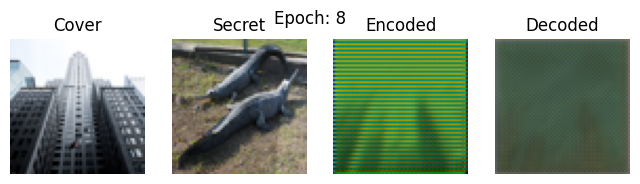

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 9 | Batch:   0 of 400. Loss AE -391068.44 | Loss Rev1   16310.87:   4%|▍         | 1/25 [00:02<00:51,  2.16s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch:  16 of 400. Loss AE -414452.97 | Loss Rev1    9919.31:   8%|▊         | 2/25 [00:04<00:49,  2.15s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch:  32 of 400. Loss AE -132841.32 | Loss Rev1    7761.76:  12%|█▏        | 3/25 [00:07<00:58,  2.66s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch:  48 of 400. Loss AE -204628.51 | Loss Rev1    6954.57:  16%|█▌        | 4/25 [00:10<00:54,  2.57s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch:  64 of 400. Loss AE -250658.69 | Loss Rev1    6200.07:  20%|██        | 5/25 [00:12<00:48,  2.42s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 9 | Batch:  80 of 400. Loss AE -277024.44 | Loss Rev1    5351.01:  24%|██▍       | 6/25 [00:14<00:44,  2.33s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch:  96 of 400. Loss AE -304329.41 | Loss Rev1    5189.98:  28%|██▊       | 7/25 [00:16<00:41,  2.28s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 9 | Batch: 112 of 400. Loss AE -209921.83 | Loss Rev1    4716.46:  32%|███▏      | 8/25 [00:19<00:44,  2.59s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 128 of 400. Loss AE -239723.43 | Loss Rev1    4491.50:  36%|███▌      | 9/25 [00:21<00:39,  2.46s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 144 of 400. Loss AE -262073.74 | Loss Rev1    4869.71:  40%|████      | 10/25 [00:24<00:35,  2.37s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 160 of 400. Loss AE -281332.57 | Loss Rev1    5025.97:  44%|████▍     | 11/25 [00:26<00:32,  2.31s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 9 | Batch: 176 of 400. Loss AE -227486.06 | Loss Rev1    5048.72:  48%|████▊     | 12/25 [00:28<00:29,  2.26s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 192 of 400. Loss AE -171724.96 | Loss Rev1    4887.17:  52%|█████▏    | 13/25 [00:31<00:30,  2.57s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 208 of 400. Loss AE -124221.30 | Loss Rev1    4810.06:  56%|█████▌    | 14/25 [00:33<00:26,  2.45s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 224 of 400. Loss AE  -82321.67 | Loss Rev1    4830.45:  60%|██████    | 15/25 [00:36<00:23,  2.36s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 240 of 400. Loss AE -107414.73 | Loss Rev1    4975.91:  64%|██████▍   | 16/25 [00:38<00:20,  2.30s/it]

1/1 [==============================] - 0s 26ms/step


Epoch 9 | Batch: 256 of 400. Loss AE  -73119.87 | Loss Rev1    4893.63:  68%|██████▊   | 17/25 [00:40<00:18,  2.26s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 272 of 400. Loss AE  -41190.25 | Loss Rev1    4783.86:  72%|███████▏  | 18/25 [00:43<00:17,  2.57s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 288 of 400. Loss AE  -20497.37 | Loss Rev1    4612.39:  76%|███████▌  | 19/25 [00:45<00:14,  2.44s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 9 | Batch: 304 of 400. Loss AE    3829.42 | Loss Rev1    4747.68:  80%|████████  | 20/25 [00:47<00:11,  2.35s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 320 of 400. Loss AE   26229.82 | Loss Rev1    4998.39:  84%|████████▍ | 21/25 [00:50<00:09,  2.30s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 336 of 400. Loss AE   42869.83 | Loss Rev1    4887.67:  88%|████████▊ | 22/25 [00:52<00:06,  2.25s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 352 of 400. Loss AE   61219.04 | Loss Rev1    5132.29:  92%|█████████▏| 23/25 [00:55<00:05,  2.56s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 368 of 400. Loss AE   78132.82 | Loss Rev1    5006.50:  96%|█████████▌| 24/25 [00:57<00:02,  2.44s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 384 of 400. Loss AE   92052.10 | Loss Rev1    5038.42: 100%|██████████| 25/25 [00:59<00:00,  2.39s/it]


1/1 [==============================] - 0s 106ms/step - loss: 88570.4531



 33%|███▎      | 1/3 [01:01<02:02, 61.13s/it]

1/1 [==============================] - 0s 105ms/step - loss: 71281.6875



 67%|██████▋   | 2/3 [01:02<00:25, 25.91s/it]

1/1 [==============================] - 0s 106ms/step - loss: 59315.6094



100%|██████████| 3/3 [01:03<00:00, 21.13s/it]

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 27ms/step


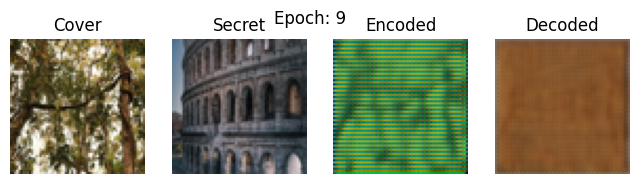

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 10 | Batch:   0 of 400. Loss AE  399846.47 | Loss Rev1    5492.48:   4%|▍         | 1/25 [00:03<01:26,  3.60s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch:  16 of 400. Loss AE  342546.36 | Loss Rev1    3581.96:   8%|▊         | 2/25 [00:05<01:03,  2.74s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch:  32 of 400. Loss AE  368531.41 | Loss Rev1    3834.82:  12%|█▏        | 3/25 [00:07<00:54,  2.48s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 10 | Batch:  48 of 400. Loss AE  351705.09 | Loss Rev1    3465.64:  16%|█▌        | 4/25 [00:10<00:49,  2.36s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 10 | Batch:  64 of 400. Loss AE  361909.74 | Loss Rev1    3108.35:  20%|██        | 5/25 [00:12<00:45,  2.30s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 10 | Batch:  80 of 400. Loss AE  371194.51 | Loss Rev1    2873.08:  24%|██▍       | 6/25 [00:15<00:49,  2.63s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch:  96 of 400. Loss AE  379926.32 | Loss Rev1    2711.47:  28%|██▊       | 7/25 [00:17<00:44,  2.47s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 10 | Batch: 112 of 400. Loss AE  380941.55 | Loss Rev1    3185.48:  32%|███▏      | 8/25 [00:19<00:40,  2.37s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 10 | Batch: 128 of 400. Loss AE  385301.55 | Loss Rev1    3516.26:  36%|███▌      | 9/25 [00:21<00:36,  2.30s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch: 144 of 400. Loss AE  386307.05 | Loss Rev1    3703.18:  40%|████      | 10/25 [00:24<00:33,  2.26s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 10 | Batch: 160 of 400. Loss AE  383883.99 | Loss Rev1    3534.81:  44%|████▍     | 11/25 [00:27<00:35,  2.57s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 10 | Batch: 176 of 400. Loss AE  373235.50 | Loss Rev1    3772.41:  48%|████▊     | 12/25 [00:29<00:31,  2.44s/it]

1/1 [==============================] - 0s 26ms/step


Epoch 10 | Batch: 192 of 400. Loss AE  373364.31 | Loss Rev1    3781.92:  52%|█████▏    | 13/25 [00:31<00:28,  2.36s/it]

1/1 [==============================] - 0s 27ms/step


Epoch 10 | Batch: 208 of 400. Loss AE  373059.12 | Loss Rev1    3878.51:  56%|█████▌    | 14/25 [00:34<00:26,  2.45s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch: 224 of 400. Loss AE  366951.81 | Loss Rev1    3813.62:  60%|██████    | 15/25 [00:36<00:23,  2.36s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 10 | Batch: 240 of 400. Loss AE  367112.61 | Loss Rev1    4497.39:  64%|██████▍   | 16/25 [00:39<00:23,  2.64s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch: 256 of 400. Loss AE  364775.73 | Loss Rev1    4552.23:  68%|██████▊   | 17/25 [00:41<00:19,  2.49s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 10 | Batch: 272 of 400. Loss AE  364771.29 | Loss Rev1    4714.05:  72%|███████▏  | 18/25 [00:44<00:16,  2.39s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 10 | Batch: 288 of 400. Loss AE  363904.07 | Loss Rev1    4566.89:  76%|███████▌  | 19/25 [00:46<00:13,  2.32s/it]

1/1 [==============================] - 0s 22ms/step


Epoch 10 | Batch: 304 of 400. Loss AE  365041.93 | Loss Rev1    4734.42:  80%|████████  | 20/25 [00:48<00:11,  2.28s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 10 | Batch: 320 of 400. Loss AE  363325.17 | Loss Rev1    4751.23:  84%|████████▍ | 21/25 [00:51<00:10,  2.58s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 10 | Batch: 336 of 400. Loss AE  362589.33 | Loss Rev1    4815.52:  88%|████████▊ | 22/25 [00:53<00:07,  2.46s/it]

1/1 [==============================] - 0s 26ms/step


Epoch 10 | Batch: 352 of 400. Loss AE  360383.25 | Loss Rev1    4827.44:  92%|█████████▏| 23/25 [00:56<00:04,  2.37s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch: 368 of 400. Loss AE  357552.78 | Loss Rev1    4721.30:  96%|█████████▌| 24/25 [00:58<00:02,  2.30s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 10 | Batch: 384 of 400. Loss AE  354098.63 | Loss Rev1    4657.04: 100%|██████████| 25/25 [01:00<00:00,  2.42s/it]


1/1 [==============================] - 0s 114ms/step - loss: 87133.8594



 33%|███▎      | 1/3 [01:01<02:03, 61.68s/it]

1/1 [==============================] - 0s 118ms/step - loss: 67696.5000



 67%|██████▋   | 2/3 [01:03<00:26, 26.18s/it]

1/1 [==============================] - 0s 107ms/step - loss: 67908.7344



100%|██████████| 3/3 [01:04<00:00, 21.45s/it]

1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 36ms/step


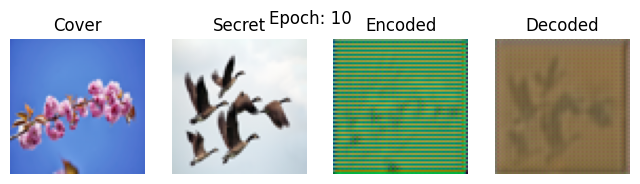

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 11 | Batch:   0 of 400. Loss AE  318795.12 | Loss Rev1    1804.71:   4%|▍         | 1/25 [00:02<00:51,  2.16s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 11 | Batch:  16 of 400. Loss AE  327531.38 | Loss Rev1    2705.10:   8%|▊         | 2/25 [00:04<00:49,  2.16s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 11 | Batch:  32 of 400. Loss AE  325608.33 | Loss Rev1    2903.73:  12%|█▏        | 3/25 [00:06<00:47,  2.17s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 11 | Batch:  48 of 400. Loss AE  329404.30 | Loss Rev1    4319.32:  16%|█▌        | 4/25 [00:09<00:55,  2.64s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 11 | Batch:  64 of 400. Loss AE  307260.56 | Loss Rev1    4434.00:  20%|██        | 5/25 [00:13<01:00,  3.02s/it]

1/1 [==============================] - 0s 56ms/step


Epoch 11 | Batch:  80 of 400. Loss AE  311215.43 | Loss Rev1    5172.38:  24%|██▍       | 6/25 [00:16<00:54,  2.88s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 11 | Batch:  96 of 400. Loss AE  311781.83 | Loss Rev1    5575.33:  28%|██▊       | 7/25 [00:18<00:47,  2.65s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch: 112 of 400. Loss AE  303080.46 | Loss Rev1    6198.81:  32%|███▏      | 8/25 [00:20<00:42,  2.49s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 11 | Batch: 128 of 400. Loss AE  292812.50 | Loss Rev1    5936.45:  36%|███▌      | 9/25 [00:22<00:38,  2.39s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 11 | Batch: 144 of 400. Loss AE  295633.18 | Loss Rev1    6085.07:  40%|████      | 10/25 [00:25<00:36,  2.43s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 11 | Batch: 160 of 400. Loss AE  296841.83 | Loss Rev1    5688.18:  44%|████▍     | 11/25 [00:27<00:34,  2.44s/it]

1/1 [==============================] - 0s 37ms/step


Epoch 11 | Batch: 176 of 400. Loss AE  296917.20 | Loss Rev1    5569.44:  48%|████▊     | 12/25 [00:29<00:30,  2.38s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch: 192 of 400. Loss AE  297400.78 | Loss Rev1    5460.54:  52%|█████▏    | 13/25 [00:32<00:27,  2.31s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch: 208 of 400. Loss AE  300395.09 | Loss Rev1    5513.49:  56%|█████▌    | 14/25 [00:34<00:24,  2.27s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 11 | Batch: 224 of 400. Loss AE  302104.39 | Loss Rev1    5327.23:  60%|██████    | 15/25 [00:36<00:23,  2.33s/it]

1/1 [==============================] - 0s 55ms/step


Epoch 11 | Batch: 240 of 400. Loss AE  294278.85 | Loss Rev1    5282.49:  64%|██████▍   | 16/25 [00:38<00:20,  2.30s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 11 | Batch: 256 of 400. Loss AE  294461.03 | Loss Rev1    5338.06:  68%|██████▊   | 17/25 [00:41<00:18,  2.25s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 11 | Batch: 272 of 400. Loss AE  291876.68 | Loss Rev1    5098.16:  72%|███████▏  | 18/25 [00:44<00:17,  2.56s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 11 | Batch: 288 of 400. Loss AE  293165.00 | Loss Rev1    4864.96:  76%|███████▌  | 19/25 [00:47<00:16,  2.80s/it]

1/1 [==============================] - 0s 71ms/step


Epoch 11 | Batch: 304 of 400. Loss AE  293355.13 | Loss Rev1    4871.97:  80%|████████  | 20/25 [00:51<00:15,  3.09s/it]

1/1 [==============================] - 0s 40ms/step


Epoch 11 | Batch: 320 of 400. Loss AE  293953.51 | Loss Rev1    5110.24:  84%|████████▍ | 21/25 [00:53<00:11,  2.84s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch: 336 of 400. Loss AE  294063.71 | Loss Rev1    4998.16:  88%|████████▊ | 22/25 [00:55<00:07,  2.63s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch: 352 of 400. Loss AE  293735.68 | Loss Rev1    4971.12:  92%|█████████▏| 23/25 [00:58<00:04,  2.50s/it]

1/1 [==============================] - 0s 30ms/step


Epoch 11 | Batch: 368 of 400. Loss AE  293380.61 | Loss Rev1    4904.28:  96%|█████████▌| 24/25 [01:00<00:02,  2.40s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch: 384 of 400. Loss AE  294014.34 | Loss Rev1    4889.80: 100%|██████████| 25/25 [01:02<00:00,  2.51s/it]


1/1 [==============================] - 0s 103ms/step - loss: 137624.8750



 33%|███▎      | 1/3 [01:03<02:07, 63.75s/it]

1/1 [==============================] - 0s 105ms/step - loss: 123199.6641



 67%|██████▋   | 2/3 [01:05<00:26, 26.99s/it]

1/1 [==============================] - 0s 109ms/step - loss: 108256.6250



100%|██████████| 3/3 [01:06<00:00, 22.09s/it]

1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 35ms/step


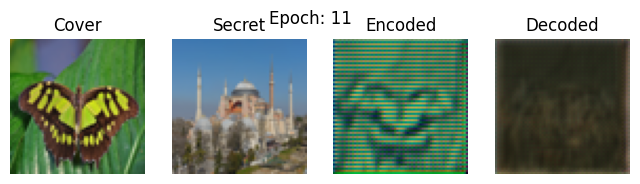

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


Epoch 12 | Batch:   0 of 400. Loss AE  284118.66 | Loss Rev1    9278.78:   4%|▍         | 1/25 [00:02<00:52,  2.17s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 12 | Batch:  16 of 400. Loss AE  299343.73 | Loss Rev1    6725.00:   8%|▊         | 2/25 [00:04<00:49,  2.17s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 12 | Batch:  32 of 400. Loss AE  301218.00 | Loss Rev1    5282.48:  12%|█▏        | 3/25 [00:06<00:50,  2.30s/it]

1/1 [==============================] - 0s 37ms/step


Epoch 12 | Batch:  48 of 400. Loss AE  303704.83 | Loss Rev1    4825.96:  16%|█▌        | 4/25 [00:10<00:56,  2.70s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 12 | Batch:  64 of 400. Loss AE  292933.96 | Loss Rev1    4781.70:  20%|██        | 5/25 [00:12<00:50,  2.50s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 12 | Batch:  80 of 400. Loss AE  279372.60 | Loss Rev1    4440.61:  24%|██▍       | 6/25 [00:14<00:45,  2.39s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 12 | Batch:  96 of 400. Loss AE  283064.46 | Loss Rev1    4428.72:  28%|██▊       | 7/25 [00:16<00:41,  2.31s/it]

1/1 [==============================] - 0s 26ms/step


Epoch 12 | Batch: 112 of 400. Loss AE  284021.83 | Loss Rev1    4519.52:  32%|███▏      | 8/25 [00:18<00:38,  2.27s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 12 | Batch: 128 of 400. Loss AE  276386.70 | Loss Rev1    4879.39:  36%|███▌      | 9/25 [00:22<00:41,  2.59s/it]

1/1 [==============================] - 0s 26ms/step


Epoch 12 | Batch: 144 of 400. Loss AE  279479.23 | Loss Rev1    4709.17:  40%|████      | 10/25 [00:24<00:36,  2.46s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 12 | Batch: 160 of 400. Loss AE  275110.35 | Loss Rev1    4599.72:  44%|████▍     | 11/25 [00:26<00:33,  2.37s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 12 | Batch: 176 of 400. Loss AE  278356.55 | Loss Rev1    4399.98:  48%|████▊     | 12/25 [00:28<00:29,  2.31s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 12 | Batch: 192 of 400. Loss AE  280140.02 | Loss Rev1    4327.75:  52%|█████▏    | 13/25 [00:30<00:27,  2.26s/it]

1/1 [==============================] - 0s 30ms/step


Epoch 12 | Batch: 208 of 400. Loss AE  280067.39 | Loss Rev1    4090.14:  56%|█████▌    | 14/25 [00:33<00:28,  2.57s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 12 | Batch: 224 of 400. Loss AE  281228.00 | Loss Rev1    3900.40:  60%|██████    | 15/25 [00:36<00:24,  2.44s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 12 | Batch: 240 of 400. Loss AE  281954.88 | Loss Rev1    4052.82:  64%|██████▍   | 16/25 [00:38<00:21,  2.36s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 12 | Batch: 256 of 400. Loss AE  277610.32 | Loss Rev1    3995.81:  68%|██████▊   | 17/25 [00:40<00:18,  2.30s/it]

1/1 [==============================] - 0s 31ms/step


Epoch 12 | Batch: 272 of 400. Loss AE  278405.26 | Loss Rev1    3972.38:  72%|███████▏  | 18/25 [00:42<00:15,  2.26s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 12 | Batch: 288 of 400. Loss AE  280007.13 | Loss Rev1    3946.09:  76%|███████▌  | 19/25 [00:46<00:15,  2.66s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 12 | Batch: 304 of 400. Loss AE  279666.77 | Loss Rev1    3871.11:  80%|████████  | 20/25 [00:49<00:14,  2.96s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 12 | Batch: 320 of 400. Loss AE  275260.55 | Loss Rev1    4089.26:  84%|████████▍ | 21/25 [00:53<00:12,  3.09s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 12 | Batch: 336 of 400. Loss AE  275671.59 | Loss Rev1    4227.16:  88%|████████▊ | 22/25 [00:56<00:09,  3.17s/it]

1/1 [==============================] - 0s 83ms/step


Epoch 12 | Batch: 352 of 400. Loss AE  275361.70 | Loss Rev1    4182.69:  92%|█████████▏| 23/25 [00:58<00:05,  2.91s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 12 | Batch: 368 of 400. Loss AE  275565.15 | Loss Rev1    4130.94:  96%|█████████▌| 24/25 [01:01<00:02,  2.68s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 12 | Batch: 384 of 400. Loss AE  276773.89 | Loss Rev1    4204.23: 100%|██████████| 25/25 [01:03<00:00,  2.53s/it]


1/1 [==============================] - 0s 106ms/step - loss: 106099.0703



 33%|███▎      | 1/3 [01:04<02:09, 64.55s/it]

1/1 [==============================] - 0s 107ms/step - loss: 86181.8281



 67%|██████▋   | 2/3 [01:05<00:27, 27.31s/it]

1/1 [==============================] - 0s 108ms/step - loss: 91470.8438



100%|██████████| 3/3 [01:07<00:00, 22.36s/it]

1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 41ms/step


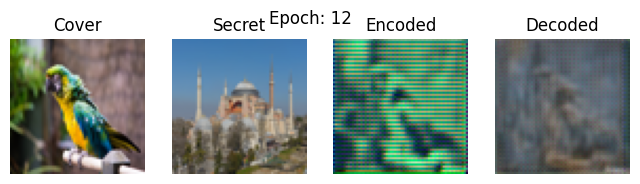

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 13 | Batch:   0 of 400. Loss AE  277185.00 | Loss Rev1    1624.78:   4%|▍         | 1/25 [00:02<00:59,  2.47s/it]

1/1 [==============================] - 0s 51ms/step


Epoch 13 | Batch:  16 of 400. Loss AE  283504.44 | Loss Rev1    3933.58:   8%|▊         | 2/25 [00:04<00:53,  2.32s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 13 | Batch:  32 of 400. Loss AE  280527.81 | Loss Rev1    4385.24:  12%|█▏        | 3/25 [00:06<00:49,  2.26s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch:  48 of 400. Loss AE  276084.95 | Loss Rev1    4936.69:  16%|█▌        | 4/25 [00:09<00:46,  2.23s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 13 | Batch:  64 of 400. Loss AE  278151.50 | Loss Rev1    4783.57:  20%|██        | 5/25 [00:11<00:44,  2.21s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 13 | Batch:  80 of 400. Loss AE  274951.82 | Loss Rev1    5202.40:  24%|██▍       | 6/25 [00:13<00:41,  2.19s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 13 | Batch:  96 of 400. Loss AE  275943.45 | Loss Rev1    5268.80:  28%|██▊       | 7/25 [00:16<00:45,  2.56s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 13 | Batch: 112 of 400. Loss AE  275530.45 | Loss Rev1    4779.66:  32%|███▏      | 8/25 [00:18<00:41,  2.43s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 13 | Batch: 128 of 400. Loss AE  274740.71 | Loss Rev1    5121.17:  36%|███▌      | 9/25 [00:21<00:37,  2.35s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch: 144 of 400. Loss AE  274150.43 | Loss Rev1    4945.43:  40%|████      | 10/25 [00:23<00:34,  2.30s/it]

1/1 [==============================] - 0s 27ms/step


Epoch 13 | Batch: 160 of 400. Loss AE  277015.47 | Loss Rev1    4964.33:  44%|████▍     | 11/25 [00:25<00:31,  2.26s/it]

1/1 [==============================] - 0s 28ms/step


Epoch 13 | Batch: 176 of 400. Loss AE  276692.95 | Loss Rev1    4939.45:  48%|████▊     | 12/25 [00:28<00:33,  2.57s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch: 192 of 400. Loss AE  278461.91 | Loss Rev1    5092.16:  52%|█████▏    | 13/25 [00:30<00:29,  2.44s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch: 208 of 400. Loss AE  277513.68 | Loss Rev1    5021.05:  56%|█████▌    | 14/25 [00:32<00:25,  2.36s/it]

1/1 [==============================] - 0s 26ms/step


Epoch 13 | Batch: 224 of 400. Loss AE  276828.45 | Loss Rev1    5375.27:  60%|██████    | 15/25 [00:35<00:23,  2.31s/it]

1/1 [==============================] - 0s 26ms/step


Epoch 13 | Batch: 240 of 400. Loss AE  270288.97 | Loss Rev1    5205.34:  64%|██████▍   | 16/25 [00:37<00:20,  2.26s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 13 | Batch: 256 of 400. Loss AE  268372.83 | Loss Rev1    5048.28:  68%|██████▊   | 17/25 [00:40<00:20,  2.57s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch: 272 of 400. Loss AE  264860.85 | Loss Rev1    4985.91:  72%|███████▏  | 18/25 [00:42<00:17,  2.44s/it]

1/1 [==============================] - 0s 30ms/step


Epoch 13 | Batch: 288 of 400. Loss AE  260037.83 | Loss Rev1    4779.03:  76%|███████▌  | 19/25 [00:44<00:14,  2.36s/it]

1/1 [==============================] - 0s 27ms/step


Epoch 13 | Batch: 304 of 400. Loss AE  254889.12 | Loss Rev1    4698.23:  80%|████████  | 20/25 [00:47<00:11,  2.30s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch: 320 of 400. Loss AE  255572.59 | Loss Rev1    4771.18:  84%|████████▍ | 21/25 [00:49<00:09,  2.26s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch: 336 of 400. Loss AE  255159.99 | Loss Rev1    4656.70:  88%|████████▊ | 22/25 [00:52<00:07,  2.56s/it]

1/1 [==============================] - 0s 29ms/step


Epoch 13 | Batch: 352 of 400. Loss AE  251827.33 | Loss Rev1    4588.01:  92%|█████████▏| 23/25 [00:54<00:04,  2.44s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch: 368 of 400. Loss AE  252847.21 | Loss Rev1    4669.79:  96%|█████████▌| 24/25 [00:56<00:02,  2.36s/it]

1/1 [==============================] - 0s 26ms/step


Epoch 13 | Batch: 384 of 400. Loss AE  253683.67 | Loss Rev1    4534.80: 100%|██████████| 25/25 [00:58<00:00,  2.36s/it]


1/1 [==============================] - 0s 107ms/step - loss: 72970.1875



 33%|███▎      | 1/3 [00:59<01:59, 59.99s/it]

1/1 [==============================] - 0s 106ms/step - loss: 51827.6250



 67%|██████▋   | 2/3 [01:01<00:25, 25.43s/it]

1/1 [==============================] - 0s 120ms/step - loss: 53031.7812



100%|██████████| 3/3 [01:02<00:00, 20.84s/it]

1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 56ms/step


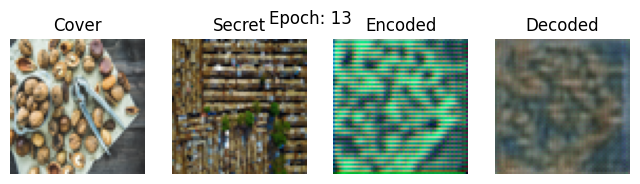

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


Epoch 14 | Batch:   0 of 400. Loss AE  258003.44 | Loss Rev1    5112.45:   4%|▍         | 1/25 [00:03<01:19,  3.31s/it]

1/1 [==============================] - 0s 26ms/step


Epoch 14 | Batch:  16 of 400. Loss AE  263637.77 | Loss Rev1    6112.58:   8%|▊         | 2/25 [00:05<01:00,  2.63s/it]

1/1 [==============================] - 0s 27ms/step


Epoch 14 | Batch:  32 of 400. Loss AE  262803.40 | Loss Rev1    5954.77:  12%|█▏        | 3/25 [00:07<00:53,  2.42s/it]

1/1 [==============================] - 0s 28ms/step


Epoch 14 | Batch:  48 of 400. Loss AE  242388.32 | Loss Rev1    7333.92:  16%|█▌        | 4/25 [00:09<00:48,  2.32s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 14 | Batch:  64 of 400. Loss AE  246634.68 | Loss Rev1    6182.91:  20%|██        | 5/25 [00:12<00:47,  2.37s/it]

1/1 [==============================] - 0s 52ms/step


Epoch 14 | Batch:  80 of 400. Loss AE  244781.91 | Loss Rev1    5555.22:  24%|██▍       | 6/25 [00:15<00:51,  2.70s/it]

1/1 [==============================] - 0s 27ms/step


Epoch 14 | Batch:  96 of 400. Loss AE  242743.27 | Loss Rev1    4843.92:  28%|██▊       | 7/25 [00:17<00:45,  2.53s/it]

1/1 [==============================] - 0s 28ms/step


Epoch 14 | Batch: 112 of 400. Loss AE  232388.31 | Loss Rev1    4981.05:  32%|███▏      | 8/25 [00:19<00:41,  2.41s/it]

1/1 [==============================] - 0s 28ms/step


Epoch 14 | Batch: 128 of 400. Loss AE  232930.06 | Loss Rev1    5007.97:  36%|███▌      | 9/25 [00:22<00:37,  2.34s/it]

1/1 [==============================] - 0s 26ms/step


Epoch 14 | Batch: 144 of 400. Loss AE  233586.40 | Loss Rev1    5510.08:  40%|████      | 10/25 [00:24<00:34,  2.29s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 14 | Batch: 160 of 400. Loss AE  232034.24 | Loss Rev1    5316.42:  44%|████▍     | 11/25 [00:27<00:36,  2.60s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 14 | Batch: 176 of 400. Loss AE  232710.05 | Loss Rev1    4987.14:  48%|████▊     | 12/25 [00:29<00:32,  2.47s/it]

1/1 [==============================] - 0s 29ms/step


Epoch 14 | Batch: 192 of 400. Loss AE  232877.81 | Loss Rev1    5173.35:  52%|█████▏    | 13/25 [00:31<00:28,  2.38s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 14 | Batch: 208 of 400. Loss AE  233291.68 | Loss Rev1    5083.84:  56%|█████▌    | 14/25 [00:34<00:25,  2.32s/it]

1/1 [==============================] - 0s 26ms/step


Epoch 14 | Batch: 224 of 400. Loss AE  232426.47 | Loss Rev1    4874.29:  60%|██████    | 15/25 [00:36<00:22,  2.27s/it]

1/1 [==============================] - 0s 27ms/step


Epoch 14 | Batch: 240 of 400. Loss AE  233148.35 | Loss Rev1    5032.40:  64%|██████▍   | 16/25 [00:39<00:23,  2.58s/it]

1/1 [==============================] - 0s 28ms/step


Epoch 14 | Batch: 256 of 400. Loss AE  233136.87 | Loss Rev1    4816.96:  68%|██████▊   | 17/25 [00:41<00:19,  2.45s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 14 | Batch: 272 of 400. Loss AE  233253.42 | Loss Rev1    4829.39:  72%|███████▏  | 18/25 [00:43<00:16,  2.37s/it]

1/1 [==============================] - 0s 27ms/step


Epoch 14 | Batch: 288 of 400. Loss AE  233006.11 | Loss Rev1    4691.65:  76%|███████▌  | 19/25 [00:46<00:13,  2.31s/it]

1/1 [==============================] - 0s 36ms/step


Epoch 14 | Batch: 304 of 400. Loss AE  232997.80 | Loss Rev1    4597.65:  80%|████████  | 20/25 [00:49<00:13,  2.69s/it]

1/1 [==============================] - 0s 51ms/step


Epoch 14 | Batch: 320 of 400. Loss AE  232411.13 | Loss Rev1    4971.60:  84%|████████▍ | 21/25 [00:51<00:10,  2.55s/it]

1/1 [==============================] - 0s 31ms/step


Epoch 14 | Batch: 336 of 400. Loss AE  232564.58 | Loss Rev1    5136.34:  88%|████████▊ | 22/25 [00:54<00:07,  2.43s/it]

1/1 [==============================] - 0s 27ms/step


Epoch 14 | Batch: 352 of 400. Loss AE  227178.26 | Loss Rev1    5063.16:  92%|█████████▏| 23/25 [00:56<00:04,  2.35s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 14 | Batch: 368 of 400. Loss AE  227621.87 | Loss Rev1    4972.97:  96%|█████████▌| 24/25 [00:58<00:02,  2.29s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 14 | Batch: 384 of 400. Loss AE  225317.78 | Loss Rev1    4828.14: 100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


1/1 [==============================] - 0s 115ms/step - loss: 66725.5703



 33%|███▎      | 1/3 [01:02<02:05, 62.76s/it]

1/1 [==============================] - 0s 113ms/step - loss: 39240.5312



 67%|██████▋   | 2/3 [01:03<00:26, 26.53s/it]

1/1 [==============================] - 0s 103ms/step - loss: 38736.3008



100%|██████████| 3/3 [01:05<00:00, 21.67s/it]

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


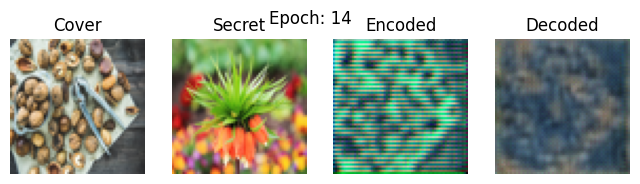

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 15 | Batch:   0 of 400. Loss AE  180516.09 | Loss Rev1    3033.50:   4%|▍         | 1/25 [00:02<00:51,  2.16s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 15 | Batch:  16 of 400. Loss AE  209283.70 | Loss Rev1    3685.46:   8%|▊         | 2/25 [00:04<00:49,  2.17s/it]

1/1 [==============================] - 0s 26ms/step


Epoch 15 | Batch:  32 of 400. Loss AE  209865.28 | Loss Rev1    4812.66:  12%|█▏        | 3/25 [00:06<00:47,  2.17s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 15 | Batch:  48 of 400. Loss AE  210970.68 | Loss Rev1    4363.31:  16%|█▌        | 4/25 [00:08<00:45,  2.17s/it]

1/1 [==============================] - 0s 28ms/step


Epoch 15 | Batch:  64 of 400. Loss AE  199644.94 | Loss Rev1    3796.66:  20%|██        | 5/25 [00:11<00:51,  2.58s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 15 | Batch:  80 of 400. Loss AE  202811.59 | Loss Rev1    3972.34:  24%|██▍       | 6/25 [00:14<00:46,  2.44s/it]

1/1 [==============================] - 0s 29ms/step


Epoch 15 | Batch:  96 of 400. Loss AE  206567.50 | Loss Rev1    3751.67:  28%|██▊       | 7/25 [00:16<00:42,  2.35s/it]

1/1 [==============================] - 0s 27ms/step


Epoch 15 | Batch: 112 of 400. Loss AE  207872.96 | Loss Rev1    4510.36:  32%|███▏      | 8/25 [00:18<00:38,  2.29s/it]

1/1 [==============================] - 0s 28ms/step


Epoch 15 | Batch: 128 of 400. Loss AE  208570.03 | Loss Rev1    4283.51:  36%|███▌      | 9/25 [00:20<00:35,  2.25s/it]

1/1 [==============================] - 0s 30ms/step


Epoch 15 | Batch: 144 of 400. Loss AE  208346.95 | Loss Rev1    3940.84:  40%|████      | 10/25 [00:22<00:33,  2.23s/it]

1/1 [==============================] - 0s 48ms/step


Epoch 15 | Batch: 160 of 400. Loss AE  207675.18 | Loss Rev1    3992.74:  44%|████▍     | 11/25 [00:25<00:31,  2.23s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 15 | Batch: 176 of 400. Loss AE  196573.71 | Loss Rev1    4010.81:  48%|████▊     | 12/25 [00:27<00:28,  2.21s/it]

1/1 [==============================] - 0s 30ms/step


Epoch 15 | Batch: 192 of 400. Loss AE  197132.16 | Loss Rev1    3891.23:  52%|█████▏    | 13/25 [00:29<00:26,  2.20s/it]

1/1 [==============================] - 0s 26ms/step


Epoch 15 | Batch: 208 of 400. Loss AE  191711.74 | Loss Rev1    3734.48:  56%|█████▌    | 14/25 [00:31<00:24,  2.19s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 15 | Batch: 224 of 400. Loss AE  191200.16 | Loss Rev1    3762.16:  60%|██████    | 15/25 [00:33<00:21,  2.19s/it]

1/1 [==============================] - 0s 28ms/step


Epoch 15 | Batch: 240 of 400. Loss AE  191589.22 | Loss Rev1    3841.81:  64%|██████▍   | 16/25 [00:36<00:20,  2.27s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 15 | Batch: 256 of 400. Loss AE  191750.82 | Loss Rev1    4429.22:  68%|██████▊   | 17/25 [00:38<00:17,  2.25s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 15 | Batch: 272 of 400. Loss AE  192252.97 | Loss Rev1    4410.82:  72%|███████▏  | 18/25 [00:40<00:15,  2.22s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 15 | Batch: 288 of 400. Loss AE  192323.77 | Loss Rev1    4214.19:  76%|███████▌  | 19/25 [00:42<00:13,  2.21s/it]

1/1 [==============================] - 0s 27ms/step


Epoch 15 | Batch: 304 of 400. Loss AE  192919.25 | Loss Rev1    4168.62:  80%|████████  | 20/25 [00:44<00:10,  2.19s/it]

1/1 [==============================] - 0s 27ms/step


Epoch 15 | Batch: 320 of 400. Loss AE  193331.13 | Loss Rev1    3999.30:  84%|████████▍ | 21/25 [00:47<00:08,  2.19s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 15 | Batch: 336 of 400. Loss AE  193309.60 | Loss Rev1    4028.42:  88%|████████▊ | 22/25 [00:50<00:07,  2.53s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 15 | Batch: 352 of 400. Loss AE  192231.45 | Loss Rev1    3895.98:  92%|█████████▏| 23/25 [00:52<00:04,  2.41s/it]

1/1 [==============================] - 0s 37ms/step


Epoch 15 | Batch: 368 of 400. Loss AE  191366.60 | Loss Rev1    3841.33:  96%|█████████▌| 24/25 [00:54<00:02,  2.34s/it]

1/1 [==============================] - 0s 38ms/step


Epoch 15 | Batch: 384 of 400. Loss AE  190494.80 | Loss Rev1    3926.15: 100%|██████████| 25/25 [00:56<00:00,  2.28s/it]


1/1 [==============================] - 0s 106ms/step - loss: 53660.3125



 33%|███▎      | 1/3 [00:57<01:55, 57.93s/it]

1/1 [==============================] - 0s 103ms/step - loss: 28375.8340



 67%|██████▋   | 2/3 [00:59<00:24, 24.61s/it]

1/1 [==============================] - 0s 118ms/step - loss: 30135.2207



100%|██████████| 3/3 [01:00<00:00, 20.17s/it]

1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 70ms/step


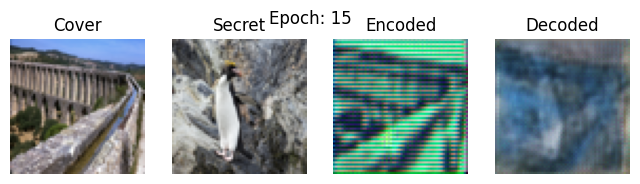

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step


Epoch 16 | Batch:   0 of 400. Loss AE  176305.56 | Loss Rev1   10702.09:   4%|▍         | 1/25 [00:02<00:53,  2.21s/it]

1/1 [==============================] - 0s 36ms/step


Epoch 16 | Batch:  16 of 400. Loss AE  160600.70 | Loss Rev1    6623.53:   8%|▊         | 2/25 [00:04<00:50,  2.19s/it]

1/1 [==============================] - 0s 28ms/step


Epoch 16 | Batch:  32 of 400. Loss AE  159639.13 | Loss Rev1    5316.15:  12%|█▏        | 3/25 [00:06<00:47,  2.17s/it]

1/1 [==============================] - 0s 28ms/step


Epoch 16 | Batch:  48 of 400. Loss AE  162456.44 | Loss Rev1    4567.20:  16%|█▌        | 4/25 [00:08<00:45,  2.17s/it]

1/1 [==============================] - 0s 30ms/step


Epoch 16 | Batch:  64 of 400. Loss AE  162331.26 | Loss Rev1    4293.04:  20%|██        | 5/25 [00:10<00:43,  2.18s/it]

1/1 [==============================] - 0s 27ms/step


Epoch 16 | Batch:  80 of 400. Loss AE  159340.15 | Loss Rev1    5559.15:  24%|██▍       | 6/25 [00:14<00:48,  2.55s/it]

1/1 [==============================] - 0s 28ms/step


Epoch 16 | Batch:  96 of 400. Loss AE  157271.53 | Loss Rev1    5107.88:  28%|██▊       | 7/25 [00:16<00:43,  2.42s/it]

1/1 [==============================] - 0s 28ms/step


Epoch 16 | Batch: 112 of 400. Loss AE  156017.96 | Loss Rev1    4577.72:  32%|███▏      | 8/25 [00:18<00:39,  2.34s/it]

1/1 [==============================] - 0s 28ms/step


Epoch 16 | Batch: 128 of 400. Loss AE  148024.90 | Loss Rev1    4383.45:  36%|███▌      | 9/25 [00:20<00:36,  2.29s/it]

1/1 [==============================] - 0s 28ms/step


Epoch 16 | Batch: 144 of 400. Loss AE  148471.15 | Loss Rev1    4571.58:  40%|████      | 10/25 [00:22<00:33,  2.25s/it]

1/1 [==============================] - 0s 28ms/step


Epoch 16 | Batch: 160 of 400. Loss AE  148821.36 | Loss Rev1    4243.24:  44%|████▍     | 11/25 [00:25<00:32,  2.31s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 16 | Batch: 176 of 400. Loss AE  149183.83 | Loss Rev1    3953.39:  48%|████▊     | 12/25 [00:27<00:29,  2.28s/it]

1/1 [==============================] - 0s 27ms/step


Epoch 16 | Batch: 192 of 400. Loss AE  145360.42 | Loss Rev1    3837.89:  52%|█████▏    | 13/25 [00:29<00:26,  2.24s/it]

1/1 [==============================] - 0s 29ms/step


Epoch 16 | Batch: 208 of 400. Loss AE  141653.42 | Loss Rev1    3937.08:  56%|█████▌    | 14/25 [00:31<00:24,  2.23s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 16 | Batch: 224 of 400. Loss AE  142091.92 | Loss Rev1    3744.64:  60%|██████    | 15/25 [00:34<00:22,  2.30s/it]

1/1 [==============================] - 0s 70ms/step


Epoch 16 | Batch: 240 of 400. Loss AE  141864.72 | Loss Rev1    4122.67:  64%|██████▍   | 16/25 [00:36<00:20,  2.29s/it]

1/1 [==============================] - 0s 42ms/step


Epoch 16 | Batch: 256 of 400. Loss AE  139278.76 | Loss Rev1    4052.93:  68%|██████▊   | 17/25 [00:39<00:20,  2.60s/it]

1/1 [==============================] - 0s 29ms/step


Epoch 16 | Batch: 272 of 400. Loss AE  139219.12 | Loss Rev1    4214.23:  72%|███████▏  | 18/25 [00:42<00:17,  2.47s/it]

1/1 [==============================] - 0s 28ms/step


Epoch 16 | Batch: 288 of 400. Loss AE  137056.90 | Loss Rev1    4110.62:  76%|███████▌  | 19/25 [00:44<00:14,  2.37s/it]

1/1 [==============================] - 0s 30ms/step


Epoch 16 | Batch: 304 of 400. Loss AE  135469.85 | Loss Rev1    3958.51:  80%|████████  | 20/25 [00:46<00:11,  2.31s/it]

1/1 [==============================] - 0s 29ms/step


Epoch 16 | Batch: 320 of 400. Loss AE  135074.48 | Loss Rev1    3915.78:  84%|████████▍ | 21/25 [00:48<00:09,  2.26s/it]

1/1 [==============================] - 0s 30ms/step


Epoch 16 | Batch: 336 of 400. Loss AE  135252.60 | Loss Rev1    3910.78:  88%|████████▊ | 22/25 [00:51<00:07,  2.57s/it]

1/1 [==============================] - 0s 29ms/step


Epoch 16 | Batch: 352 of 400. Loss AE  135001.39 | Loss Rev1    3878.11:  92%|█████████▏| 23/25 [00:53<00:04,  2.44s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 16 | Batch: 368 of 400. Loss AE  134627.33 | Loss Rev1    3823.71:  96%|█████████▌| 24/25 [00:56<00:02,  2.37s/it]

1/1 [==============================] - 0s 31ms/step


Epoch 16 | Batch: 384 of 400. Loss AE  134516.53 | Loss Rev1    3797.67: 100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


1/1 [==============================] - 0s 107ms/step - loss: 44376.1406



 33%|███▎      | 1/3 [00:59<01:59, 59.58s/it]

1/1 [==============================] - 0s 105ms/step - loss: 19589.5977



 67%|██████▋   | 2/3 [01:00<00:25, 25.16s/it]

1/1 [==============================] - 0s 117ms/step - loss: 14289.3330



100%|██████████| 3/3 [01:01<00:00, 20.66s/it]

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 51ms/step


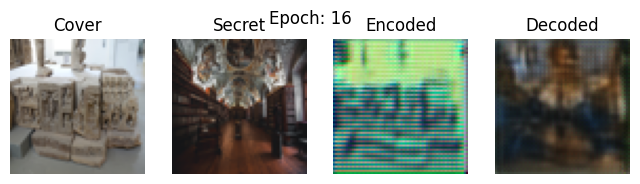

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 17 | Batch:   0 of 400. Loss AE  115339.11 | Loss Rev1    2637.86:   4%|▍         | 1/25 [00:02<00:53,  2.22s/it]

1/1 [==============================] - 0s 30ms/step


Epoch 17 | Batch:  16 of 400. Loss AE  123177.12 | Loss Rev1    2982.14:   8%|▊         | 2/25 [00:04<00:50,  2.20s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 17 | Batch:  32 of 400. Loss AE  124473.29 | Loss Rev1    2722.39:  12%|█▏        | 3/25 [00:06<00:48,  2.18s/it]

1/1 [==============================] - 0s 30ms/step


Epoch 17 | Batch:  48 of 400. Loss AE  124218.21 | Loss Rev1    4839.19:  16%|█▌        | 4/25 [00:08<00:45,  2.18s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 17 | Batch:  64 of 400. Loss AE  113738.67 | Loss Rev1    4291.92:  20%|██        | 5/25 [00:10<00:43,  2.18s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 17 | Batch:  80 of 400. Loss AE  105972.71 | Loss Rev1    4172.17:  24%|██▍       | 6/25 [00:14<00:48,  2.55s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 17 | Batch:  96 of 400. Loss AE  106755.23 | Loss Rev1    4588.72:  28%|██▊       | 7/25 [00:16<00:43,  2.42s/it]

1/1 [==============================] - 0s 30ms/step


Epoch 17 | Batch: 112 of 400. Loss AE  105829.73 | Loss Rev1    4230.74:  32%|███▏      | 8/25 [00:18<00:39,  2.35s/it]

1/1 [==============================] - 0s 30ms/step


Epoch 17 | Batch: 128 of 400. Loss AE  107135.93 | Loss Rev1    3935.59:  36%|███▌      | 9/25 [00:20<00:36,  2.29s/it]

1/1 [==============================] - 0s 26ms/step


Epoch 17 | Batch: 144 of 400. Loss AE  108474.45 | Loss Rev1    3820.19:  40%|████      | 10/25 [00:22<00:33,  2.26s/it]

1/1 [==============================] - 0s 31ms/step


Epoch 17 | Batch: 160 of 400. Loss AE  109126.33 | Loss Rev1    3684.79:  44%|████▍     | 11/25 [00:26<00:35,  2.57s/it]

1/1 [==============================] - 0s 48ms/step


Epoch 17 | Batch: 176 of 400. Loss AE  104956.02 | Loss Rev1    4153.40:  48%|████▊     | 12/25 [00:28<00:31,  2.45s/it]

1/1 [==============================] - 0s 29ms/step


Epoch 17 | Batch: 192 of 400. Loss AE  103998.47 | Loss Rev1    4156.66:  52%|█████▏    | 13/25 [00:30<00:28,  2.37s/it]

1/1 [==============================] - 0s 29ms/step


Epoch 17 | Batch: 208 of 400. Loss AE  104897.73 | Loss Rev1    4047.92:  56%|█████▌    | 14/25 [00:32<00:25,  2.31s/it]

1/1 [==============================] - 0s 30ms/step


Epoch 17 | Batch: 224 of 400. Loss AE  105000.16 | Loss Rev1    3982.18:  60%|██████    | 15/25 [00:34<00:22,  2.27s/it]

1/1 [==============================] - 0s 31ms/step


Epoch 17 | Batch: 240 of 400. Loss AE  104915.99 | Loss Rev1    4194.38:  64%|██████▍   | 16/25 [00:37<00:20,  2.32s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 17 | Batch: 256 of 400. Loss AE  105115.91 | Loss Rev1    4109.36:  68%|██████▊   | 17/25 [00:40<00:20,  2.62s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 17 | Batch: 272 of 400. Loss AE  103861.11 | Loss Rev1    4049.57:  72%|███████▏  | 18/25 [00:42<00:17,  2.49s/it]

1/1 [==============================] - 0s 31ms/step


Epoch 17 | Batch: 288 of 400. Loss AE  101463.15 | Loss Rev1    4264.90:  76%|███████▌  | 19/25 [00:45<00:14,  2.40s/it]

1/1 [==============================] - 0s 30ms/step


Epoch 17 | Batch: 304 of 400. Loss AE   99660.41 | Loss Rev1    4587.16:  80%|████████  | 20/25 [00:47<00:11,  2.33s/it]

1/1 [==============================] - 0s 29ms/step


Epoch 17 | Batch: 320 of 400. Loss AE  100049.31 | Loss Rev1    4747.57:  84%|████████▍ | 21/25 [00:49<00:09,  2.28s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 17 | Batch: 336 of 400. Loss AE   99640.42 | Loss Rev1    4666.24:  88%|████████▊ | 22/25 [00:52<00:07,  2.60s/it]

1/1 [==============================] - 0s 31ms/step


Epoch 17 | Batch: 352 of 400. Loss AE   99537.99 | Loss Rev1    4569.01:  92%|█████████▏| 23/25 [00:54<00:04,  2.47s/it]

1/1 [==============================] - 0s 29ms/step


Epoch 17 | Batch: 368 of 400. Loss AE   98775.67 | Loss Rev1    4605.47:  96%|█████████▌| 24/25 [00:57<00:02,  2.37s/it]

1/1 [==============================] - 0s 27ms/step


Epoch 17 | Batch: 384 of 400. Loss AE   98538.29 | Loss Rev1    4554.33: 100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


1/1 [==============================] - 0s 106ms/step - loss: 40149.2617



 33%|███▎      | 1/3 [01:00<02:00, 60.41s/it]

1/1 [==============================] - 0s 116ms/step - loss: 17679.6836



 67%|██████▋   | 2/3 [01:01<00:25, 25.62s/it]

1/1 [==============================] - 0s 110ms/step - loss: 19620.6230



100%|██████████| 3/3 [01:02<00:00, 20.96s/it]

1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 40ms/step


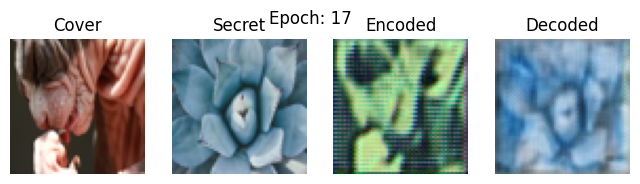

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 18 | Batch:   0 of 400. Loss AE   88527.34 | Loss Rev1    2672.83:   4%|▍         | 1/25 [00:02<00:52,  2.20s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 18 | Batch:  16 of 400. Loss AE   65548.66 | Loss Rev1    1921.45:   8%|▊         | 2/25 [00:04<00:50,  2.18s/it]

1/1 [==============================] - 0s 31ms/step


Epoch 18 | Batch:  32 of 400. Loss AE   73904.55 | Loss Rev1    2572.71:  12%|█▏        | 3/25 [00:06<00:48,  2.18s/it]

1/1 [==============================] - 0s 31ms/step


Epoch 18 | Batch:  48 of 400. Loss AE   61082.36 | Loss Rev1    3146.50:  16%|█▌        | 4/25 [00:08<00:45,  2.18s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 18 | Batch:  64 of 400. Loss AE   62989.70 | Loss Rev1    3473.05:  20%|██        | 5/25 [00:11<00:45,  2.28s/it]

1/1 [==============================] - 0s 44ms/step


Epoch 18 | Batch:  80 of 400. Loss AE   65904.90 | Loss Rev1    4017.15:  24%|██▍       | 6/25 [00:13<00:44,  2.35s/it]

1/1 [==============================] - 0s 36ms/step


Epoch 18 | Batch:  96 of 400. Loss AE   69080.16 | Loss Rev1    4264.09:  28%|██▊       | 7/25 [00:15<00:41,  2.30s/it]

1/1 [==============================] - 0s 31ms/step


Epoch 18 | Batch: 112 of 400. Loss AE   70858.19 | Loss Rev1    3850.68:  32%|███▏      | 8/25 [00:18<00:38,  2.26s/it]

1/1 [==============================] - 0s 39ms/step


Epoch 18 | Batch: 128 of 400. Loss AE   70228.28 | Loss Rev1    3770.47:  36%|███▌      | 9/25 [00:20<00:35,  2.23s/it]

1/1 [==============================] - 0s 31ms/step


Epoch 18 | Batch: 144 of 400. Loss AE   70041.86 | Loss Rev1    3504.28:  40%|████      | 10/25 [00:22<00:33,  2.22s/it]

1/1 [==============================] - 0s 25ms/step


Epoch 18 | Batch: 160 of 400. Loss AE   71004.77 | Loss Rev1    3514.66:  44%|████▍     | 11/25 [00:25<00:36,  2.64s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 18 | Batch: 176 of 400. Loss AE   71622.33 | Loss Rev1    3580.44:  48%|████▊     | 12/25 [00:28<00:32,  2.49s/it]

1/1 [==============================] - 0s 37ms/step


Epoch 18 | Batch: 192 of 400. Loss AE   72450.33 | Loss Rev1    3919.61:  52%|█████▏    | 13/25 [00:30<00:29,  2.48s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 18 | Batch: 208 of 400. Loss AE   73453.17 | Loss Rev1    4087.37:  56%|█████▌    | 14/25 [00:33<00:30,  2.73s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 18 | Batch: 224 of 400. Loss AE   73803.42 | Loss Rev1    3977.76:  60%|██████    | 15/25 [00:36<00:25,  2.56s/it]

1/1 [==============================] - 0s 38ms/step


Epoch 18 | Batch: 240 of 400. Loss AE   73009.23 | Loss Rev1    4123.34:  64%|██████▍   | 16/25 [00:39<00:25,  2.78s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 18 | Batch: 256 of 400. Loss AE   73125.95 | Loss Rev1    4081.03:  68%|██████▊   | 17/25 [00:41<00:20,  2.59s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 18 | Batch: 272 of 400. Loss AE   73036.38 | Loss Rev1    3949.62:  72%|███████▏  | 18/25 [00:44<00:17,  2.56s/it]

1/1 [==============================] - 0s 29ms/step


Epoch 18 | Batch: 288 of 400. Loss AE   70389.65 | Loss Rev1    3986.68:  76%|███████▌  | 19/25 [00:46<00:14,  2.45s/it]

1/1 [==============================] - 0s 29ms/step


Epoch 18 | Batch: 304 of 400. Loss AE   70404.16 | Loss Rev1    3862.14:  80%|████████  | 20/25 [00:48<00:11,  2.36s/it]

1/1 [==============================] - 0s 40ms/step


Epoch 18 | Batch: 320 of 400. Loss AE   70363.81 | Loss Rev1    3780.82:  84%|████████▍ | 21/25 [00:51<00:10,  2.64s/it]

1/1 [==============================] - 0s 31ms/step


Epoch 18 | Batch: 336 of 400. Loss AE   70411.95 | Loss Rev1    3699.19:  88%|████████▊ | 22/25 [00:53<00:07,  2.50s/it]

1/1 [==============================] - 0s 31ms/step


Epoch 18 | Batch: 352 of 400. Loss AE   69124.21 | Loss Rev1    3719.84:  92%|█████████▏| 23/25 [00:55<00:04,  2.40s/it]

1/1 [==============================] - 0s 43ms/step


Epoch 18 | Batch: 368 of 400. Loss AE   69090.13 | Loss Rev1    3720.70:  96%|█████████▌| 24/25 [00:58<00:02,  2.34s/it]

1/1 [==============================] - 0s 31ms/step


Epoch 18 | Batch: 384 of 400. Loss AE   69176.56 | Loss Rev1    3772.21: 100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


1/1 [==============================] - 0s 119ms/step - loss: 37009.3359



 33%|███▎      | 1/3 [01:01<02:03, 61.65s/it]

1/1 [==============================] - 0s 123ms/step - loss: 15405.9111



 67%|██████▋   | 2/3 [01:02<00:26, 26.04s/it]

1/1 [==============================] - 0s 115ms/step - loss: 13122.6797



100%|██████████| 3/3 [01:03<00:00, 21.30s/it]

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 35ms/step


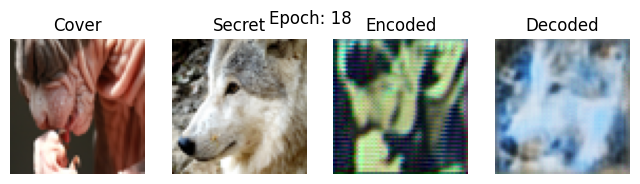

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 19 | Batch:   0 of 400. Loss AE   74212.81 | Loss Rev1    4131.78:   4%|▍         | 1/25 [00:02<00:52,  2.18s/it]

1/1 [==============================] - 0s 31ms/step


Epoch 19 | Batch:  16 of 400. Loss AE   72060.20 | Loss Rev1    2775.78:   8%|▊         | 2/25 [00:04<00:50,  2.18s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 19 | Batch:  32 of 400. Loss AE   68293.56 | Loss Rev1    2188.34:  12%|█▏        | 3/25 [00:06<00:47,  2.18s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 19 | Batch:  48 of 400. Loss AE   66883.14 | Loss Rev1    2585.28:  16%|█▌        | 4/25 [00:08<00:45,  2.17s/it]

1/1 [==============================] - 0s 30ms/step


Epoch 19 | Batch:  64 of 400. Loss AE   64949.43 | Loss Rev1    2267.15:  20%|██        | 5/25 [00:11<00:51,  2.57s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 19 | Batch:  80 of 400. Loss AE   64631.86 | Loss Rev1    2145.08:  24%|██▍       | 6/25 [00:14<00:46,  2.44s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 19 | Batch:  96 of 400. Loss AE   65044.73 | Loss Rev1    2686.71:  28%|██▊       | 7/25 [00:16<00:42,  2.35s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 19 | Batch: 112 of 400. Loss AE   60699.08 | Loss Rev1    3390.37:  32%|███▏      | 8/25 [00:18<00:39,  2.30s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 19 | Batch: 128 of 400. Loss AE   60705.20 | Loss Rev1    4382.43:  36%|███▌      | 9/25 [00:20<00:36,  2.26s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 19 | Batch: 144 of 400. Loss AE   60333.60 | Loss Rev1    4267.78:  40%|████      | 10/25 [00:23<00:38,  2.57s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 19 | Batch: 160 of 400. Loss AE   56637.41 | Loss Rev1    4115.91:  44%|████▍     | 11/25 [00:26<00:34,  2.45s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 19 | Batch: 176 of 400. Loss AE   55673.28 | Loss Rev1    4084.62:  48%|████▊     | 12/25 [00:28<00:30,  2.37s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 19 | Batch: 192 of 400. Loss AE   52759.86 | Loss Rev1    3850.82:  52%|█████▏    | 13/25 [00:30<00:27,  2.31s/it]

1/1 [==============================] - 0s 47ms/step


Epoch 19 | Batch: 208 of 400. Loss AE   51592.21 | Loss Rev1    3919.19:  56%|█████▌    | 14/25 [00:32<00:24,  2.27s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 19 | Batch: 224 of 400. Loss AE   50336.18 | Loss Rev1    3794.28:  60%|██████    | 15/25 [00:35<00:25,  2.57s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 19 | Batch: 240 of 400. Loss AE   50416.66 | Loss Rev1    3734.55:  64%|██████▍   | 16/25 [00:39<00:25,  2.79s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 19 | Batch: 256 of 400. Loss AE   50510.08 | Loss Rev1    3626.41:  68%|██████▊   | 17/25 [00:41<00:20,  2.60s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 19 | Batch: 272 of 400. Loss AE   50577.61 | Loss Rev1    3818.69:  72%|███████▏  | 18/25 [00:43<00:17,  2.47s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 19 | Batch: 288 of 400. Loss AE   50819.17 | Loss Rev1    3729.46:  76%|███████▌  | 19/25 [00:46<00:14,  2.47s/it]

1/1 [==============================] - 0s 69ms/step


Epoch 19 | Batch: 304 of 400. Loss AE   50701.99 | Loss Rev1    3738.25:  80%|████████  | 20/25 [00:49<00:13,  2.73s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 19 | Batch: 320 of 400. Loss AE   50603.17 | Loss Rev1    3730.91:  84%|████████▍ | 21/25 [00:51<00:10,  2.56s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 19 | Batch: 336 of 400. Loss AE   50467.79 | Loss Rev1    3666.33:  88%|████████▊ | 22/25 [00:53<00:07,  2.44s/it]

1/1 [==============================] - 0s 30ms/step


Epoch 19 | Batch: 352 of 400. Loss AE   49247.98 | Loss Rev1    3706.15:  92%|█████████▏| 23/25 [00:55<00:04,  2.36s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 19 | Batch: 368 of 400. Loss AE   49323.89 | Loss Rev1    3664.36:  96%|█████████▌| 24/25 [00:58<00:02,  2.30s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 19 | Batch: 384 of 400. Loss AE   49776.47 | Loss Rev1    4136.52: 100%|██████████| 25/25 [01:01<00:00,  2.45s/it]


1/1 [==============================] - 0s 107ms/step - loss: 40343.7500



 33%|███▎      | 1/3 [01:02<02:05, 62.58s/it]

1/1 [==============================] - 0s 104ms/step - loss: 8144.8760



 67%|██████▋   | 2/3 [01:03<00:26, 26.51s/it]

1/1 [==============================] - 0s 107ms/step - loss: 4412.8213



100%|██████████| 3/3 [01:05<00:00, 21.69s/it]

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


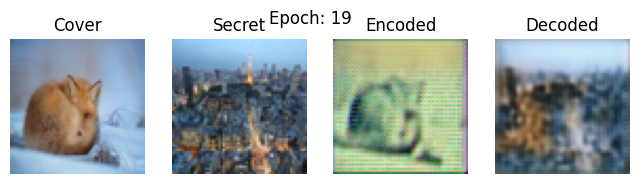

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 20 | Batch:   0 of 400. Loss AE   40334.83 | Loss Rev1    5017.73:   4%|▍         | 1/25 [00:02<00:52,  2.18s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 20 | Batch:  16 of 400. Loss AE   41869.99 | Loss Rev1    5039.30:   8%|▊         | 2/25 [00:04<00:50,  2.18s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 20 | Batch:  32 of 400. Loss AE   43142.35 | Loss Rev1    4439.31:  12%|█▏        | 3/25 [00:07<00:59,  2.68s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 20 | Batch:  48 of 400. Loss AE   36157.45 | Loss Rev1    3924.47:  16%|█▌        | 4/25 [00:09<00:52,  2.48s/it]

1/1 [==============================] - 0s 36ms/step


Epoch 20 | Batch:  64 of 400. Loss AE   36183.81 | Loss Rev1    3352.01:  20%|██        | 5/25 [00:12<00:47,  2.37s/it]

1/1 [==============================] - 0s 44ms/step


Epoch 20 | Batch:  80 of 400. Loss AE   36055.65 | Loss Rev1    3010.70:  24%|██▍       | 6/25 [00:14<00:43,  2.31s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 20 | Batch:  96 of 400. Loss AE   35007.67 | Loss Rev1    2971.85:  28%|██▊       | 7/25 [00:16<00:40,  2.27s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 20 | Batch: 112 of 400. Loss AE   35071.93 | Loss Rev1    2796.11:  32%|███▏      | 8/25 [00:19<00:43,  2.59s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 20 | Batch: 128 of 400. Loss AE   36050.39 | Loss Rev1    3322.26:  36%|███▌      | 9/25 [00:21<00:39,  2.46s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 20 | Batch: 144 of 400. Loss AE   36352.53 | Loss Rev1    3327.12:  40%|████      | 10/25 [00:23<00:35,  2.37s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 20 | Batch: 160 of 400. Loss AE   36268.67 | Loss Rev1    3309.35:  44%|████▍     | 11/25 [00:26<00:32,  2.31s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 20 | Batch: 176 of 400. Loss AE   36306.62 | Loss Rev1    3273.74:  48%|████▊     | 12/25 [00:28<00:29,  2.27s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 20 | Batch: 192 of 400. Loss AE   36525.98 | Loss Rev1    3557.78:  52%|█████▏    | 13/25 [00:31<00:30,  2.57s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 20 | Batch: 208 of 400. Loss AE   36964.67 | Loss Rev1    3542.30:  56%|█████▌    | 14/25 [00:33<00:26,  2.45s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 20 | Batch: 224 of 400. Loss AE   35358.37 | Loss Rev1    3654.97:  60%|██████    | 15/25 [00:35<00:23,  2.37s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 20 | Batch: 240 of 400. Loss AE   35928.81 | Loss Rev1    3928.57:  64%|██████▍   | 16/25 [00:38<00:20,  2.31s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 20 | Batch: 256 of 400. Loss AE   34611.48 | Loss Rev1    3976.50:  68%|██████▊   | 17/25 [00:40<00:18,  2.28s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 20 | Batch: 272 of 400. Loss AE   34688.31 | Loss Rev1    4008.94:  72%|███████▏  | 18/25 [00:43<00:18,  2.58s/it]

1/1 [==============================] - 0s 36ms/step


Epoch 20 | Batch: 288 of 400. Loss AE   34779.10 | Loss Rev1    3886.85:  76%|███████▌  | 19/25 [00:45<00:14,  2.46s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 20 | Batch: 304 of 400. Loss AE   35204.29 | Loss Rev1    3871.60:  80%|████████  | 20/25 [00:47<00:11,  2.37s/it]

1/1 [==============================] - 0s 45ms/step


Epoch 20 | Batch: 320 of 400. Loss AE   35050.62 | Loss Rev1    3836.16:  84%|████████▍ | 21/25 [00:50<00:09,  2.31s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 20 | Batch: 336 of 400. Loss AE   34975.87 | Loss Rev1    4095.15:  88%|████████▊ | 22/25 [00:52<00:06,  2.27s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 20 | Batch: 352 of 400. Loss AE   34290.83 | Loss Rev1    4601.05:  92%|█████████▏| 23/25 [00:55<00:05,  2.58s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 20 | Batch: 368 of 400. Loss AE   34180.65 | Loss Rev1    4564.30:  96%|█████████▌| 24/25 [00:57<00:02,  2.45s/it]

1/1 [==============================] - 0s 36ms/step


Epoch 20 | Batch: 384 of 400. Loss AE   34207.11 | Loss Rev1    4491.66: 100%|██████████| 25/25 [00:59<00:00,  2.40s/it]


1/1 [==============================] - 0s 106ms/step - loss: 35352.3125



 33%|███▎      | 1/3 [01:01<02:02, 61.16s/it]

1/1 [==============================] - 0s 104ms/step - loss: 14931.9092



 67%|██████▋   | 2/3 [01:02<00:25, 25.79s/it]

1/1 [==============================] - 0s 105ms/step - loss: 12151.8750



100%|██████████| 3/3 [01:03<00:00, 21.08s/it]

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 37ms/step


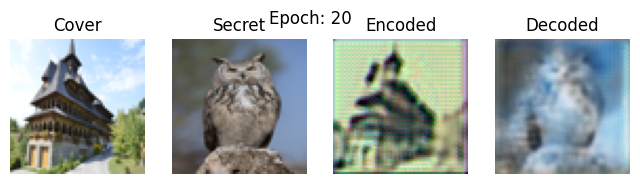

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 21 | Batch:   0 of 400. Loss AE   12614.41 | Loss Rev1    5751.78:   4%|▍         | 1/25 [00:02<00:59,  2.48s/it]

1/1 [==============================] - 0s 55ms/step


Epoch 21 | Batch:  16 of 400. Loss AE    8381.67 | Loss Rev1    4038.32:   8%|▊         | 2/25 [00:04<00:53,  2.32s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 21 | Batch:  32 of 400. Loss AE   14958.29 | Loss Rev1    3119.31:  12%|█▏        | 3/25 [00:06<00:49,  2.26s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 21 | Batch:  48 of 400. Loss AE   18432.21 | Loss Rev1    2889.98:  16%|█▌        | 4/25 [00:09<00:46,  2.23s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 21 | Batch:  64 of 400. Loss AE   18111.22 | Loss Rev1    3020.15:  20%|██        | 5/25 [00:11<00:44,  2.21s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 21 | Batch:  80 of 400. Loss AE   19339.39 | Loss Rev1    3400.43:  24%|██▍       | 6/25 [00:13<00:41,  2.20s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 21 | Batch:  96 of 400. Loss AE   20412.72 | Loss Rev1    3519.64:  28%|██▊       | 7/25 [00:16<00:45,  2.55s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 21 | Batch: 112 of 400. Loss AE   21411.67 | Loss Rev1    3449.11:  32%|███▏      | 8/25 [00:18<00:41,  2.42s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 21 | Batch: 128 of 400. Loss AE   20788.84 | Loss Rev1    3166.75:  36%|███▌      | 9/25 [00:21<00:37,  2.35s/it]

1/1 [==============================] - 0s 43ms/step


Epoch 21 | Batch: 144 of 400. Loss AE   21710.95 | Loss Rev1    3388.59:  40%|████      | 10/25 [00:23<00:34,  2.30s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 21 | Batch: 160 of 400. Loss AE   22825.38 | Loss Rev1    3400.41:  44%|████▍     | 11/25 [00:25<00:31,  2.26s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 21 | Batch: 176 of 400. Loss AE   22929.69 | Loss Rev1    3229.00:  48%|████▊     | 12/25 [00:28<00:33,  2.57s/it]

1/1 [==============================] - 0s 36ms/step


Epoch 21 | Batch: 192 of 400. Loss AE   23154.25 | Loss Rev1    3220.98:  52%|█████▏    | 13/25 [00:30<00:29,  2.45s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 21 | Batch: 208 of 400. Loss AE   23649.35 | Loss Rev1    3733.31:  56%|█████▌    | 14/25 [00:33<00:26,  2.37s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 21 | Batch: 224 of 400. Loss AE   23928.43 | Loss Rev1    3594.93:  60%|██████    | 15/25 [00:35<00:23,  2.31s/it]

1/1 [==============================] - 0s 36ms/step


Epoch 21 | Batch: 240 of 400. Loss AE   23212.01 | Loss Rev1    3803.24:  64%|██████▍   | 16/25 [00:37<00:20,  2.27s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 21 | Batch: 256 of 400. Loss AE   23483.21 | Loss Rev1    3715.15:  68%|██████▊   | 17/25 [00:40<00:20,  2.58s/it]

1/1 [==============================] - 0s 36ms/step


Epoch 21 | Batch: 272 of 400. Loss AE   23523.77 | Loss Rev1    3813.24:  72%|███████▏  | 18/25 [00:42<00:17,  2.45s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 21 | Batch: 288 of 400. Loss AE   23515.95 | Loss Rev1    3715.23:  76%|███████▌  | 19/25 [00:44<00:14,  2.37s/it]

1/1 [==============================] - 0s 38ms/step


Epoch 21 | Batch: 304 of 400. Loss AE   23525.17 | Loss Rev1    3586.70:  80%|████████  | 20/25 [00:47<00:11,  2.31s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 21 | Batch: 320 of 400. Loss AE   24058.05 | Loss Rev1    3840.26:  84%|████████▍ | 21/25 [00:49<00:09,  2.27s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 21 | Batch: 336 of 400. Loss AE   23951.11 | Loss Rev1    3754.08:  88%|████████▊ | 22/25 [00:52<00:07,  2.57s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 21 | Batch: 352 of 400. Loss AE   24103.65 | Loss Rev1    3865.05:  92%|█████████▏| 23/25 [00:54<00:04,  2.45s/it]

1/1 [==============================] - 0s 37ms/step


Epoch 21 | Batch: 368 of 400. Loss AE   23900.16 | Loss Rev1    3849.69:  96%|█████████▌| 24/25 [00:56<00:02,  2.37s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 21 | Batch: 384 of 400. Loss AE   23637.18 | Loss Rev1    3767.57: 100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


1/1 [==============================] - 0s 115ms/step - loss: 57911.8945



 33%|███▎      | 1/3 [01:00<02:00, 60.15s/it]

1/1 [==============================] - 0s 106ms/step - loss: 57352.6523



 67%|██████▋   | 2/3 [01:01<00:25, 25.53s/it]

1/1 [==============================] - 0s 115ms/step - loss: 42963.9297



100%|██████████| 3/3 [01:02<00:00, 20.93s/it]

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 32ms/step


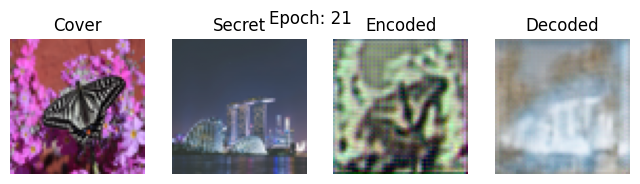

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 55ms/step


Epoch 22 | Batch:   0 of 400. Loss AE   19374.84 | Loss Rev1    6633.35:   4%|▍         | 1/25 [00:03<01:19,  3.32s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 22 | Batch:  16 of 400. Loss AE   19450.08 | Loss Rev1    6157.10:   8%|▊         | 2/25 [00:05<01:00,  2.65s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 22 | Batch:  32 of 400. Loss AE   19106.10 | Loss Rev1    5849.47:  12%|█▏        | 3/25 [00:07<00:53,  2.43s/it]

1/1 [==============================] - 0s 41ms/step


Epoch 22 | Batch:  48 of 400. Loss AE   17978.17 | Loss Rev1    4815.10:  16%|█▌        | 4/25 [00:10<00:51,  2.45s/it]

1/1 [==============================] - 0s 37ms/step


Epoch 22 | Batch:  64 of 400. Loss AE   18360.32 | Loss Rev1    5743.84:  20%|██        | 5/25 [00:13<00:55,  2.76s/it]

1/1 [==============================] - 0s 51ms/step


Epoch 22 | Batch:  80 of 400. Loss AE   18899.46 | Loss Rev1    6496.76:  24%|██▍       | 6/25 [00:15<00:48,  2.56s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 22 | Batch:  96 of 400. Loss AE   17558.72 | Loss Rev1    6453.78:  28%|██▊       | 7/25 [00:17<00:43,  2.43s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 22 | Batch: 112 of 400. Loss AE   17888.93 | Loss Rev1    6636.79:  32%|███▏      | 8/25 [00:19<00:39,  2.35s/it]

1/1 [==============================] - 0s 49ms/step


Epoch 22 | Batch: 128 of 400. Loss AE   17888.53 | Loss Rev1    6128.75:  36%|███▌      | 9/25 [00:22<00:36,  2.30s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 22 | Batch: 144 of 400. Loss AE   17176.95 | Loss Rev1    6015.09:  40%|████      | 10/25 [00:24<00:33,  2.26s/it]

1/1 [==============================] - 0s 58ms/step


Epoch 22 | Batch: 160 of 400. Loss AE   17957.16 | Loss Rev1    5960.10:  44%|████▍     | 11/25 [00:27<00:36,  2.59s/it]

1/1 [==============================] - 0s 37ms/step


Epoch 22 | Batch: 176 of 400. Loss AE   18268.29 | Loss Rev1    5872.78:  48%|████▊     | 12/25 [00:29<00:32,  2.47s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 22 | Batch: 192 of 400. Loss AE   18228.53 | Loss Rev1    5595.66:  52%|█████▏    | 13/25 [00:32<00:28,  2.38s/it]

1/1 [==============================] - 0s 36ms/step


Epoch 22 | Batch: 208 of 400. Loss AE   18517.37 | Loss Rev1    5720.67:  56%|█████▌    | 14/25 [00:34<00:25,  2.32s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 22 | Batch: 224 of 400. Loss AE   17764.68 | Loss Rev1    5478.23:  60%|██████    | 15/25 [00:36<00:22,  2.28s/it]

1/1 [==============================] - 0s 50ms/step


Epoch 22 | Batch: 240 of 400. Loss AE   17879.78 | Loss Rev1    5319.88:  64%|██████▍   | 16/25 [00:39<00:23,  2.59s/it]

1/1 [==============================] - 0s 39ms/step


Epoch 22 | Batch: 256 of 400. Loss AE   18184.11 | Loss Rev1    5166.85:  68%|██████▊   | 17/25 [00:41<00:19,  2.46s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 22 | Batch: 272 of 400. Loss AE   17791.87 | Loss Rev1    4992.00:  72%|███████▏  | 18/25 [00:44<00:16,  2.37s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 22 | Batch: 288 of 400. Loss AE   17699.84 | Loss Rev1    4825.14:  76%|███████▌  | 19/25 [00:46<00:13,  2.32s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 22 | Batch: 304 of 400. Loss AE   17472.74 | Loss Rev1    4670.58:  80%|████████  | 20/25 [00:48<00:11,  2.27s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 22 | Batch: 320 of 400. Loss AE   17508.19 | Loss Rev1    4607.96:  84%|████████▍ | 21/25 [00:50<00:08,  2.25s/it]

1/1 [==============================] - 0s 37ms/step


Epoch 22 | Batch: 336 of 400. Loss AE   17222.70 | Loss Rev1    4458.44:  88%|████████▊ | 22/25 [00:52<00:06,  2.23s/it]

1/1 [==============================] - 0s 37ms/step


Epoch 22 | Batch: 352 of 400. Loss AE   17323.13 | Loss Rev1    4308.62:  92%|█████████▏| 23/25 [00:55<00:04,  2.30s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 22 | Batch: 368 of 400. Loss AE   17054.34 | Loss Rev1    4263.81:  96%|█████████▌| 24/25 [00:57<00:02,  2.27s/it]

1/1 [==============================] - 0s 36ms/step


Epoch 22 | Batch: 384 of 400. Loss AE   16957.17 | Loss Rev1    4186.23: 100%|██████████| 25/25 [00:59<00:00,  2.38s/it]


1/1 [==============================] - 0s 106ms/step - loss: 47592.1016



 33%|███▎      | 1/3 [01:00<02:01, 60.84s/it]

1/1 [==============================] - 0s 119ms/step - loss: 32931.3398



 67%|██████▋   | 2/3 [01:02<00:25, 25.82s/it]

1/1 [==============================] - 0s 114ms/step - loss: 26200.1875



100%|██████████| 3/3 [01:03<00:00, 21.11s/it]

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 48ms/step


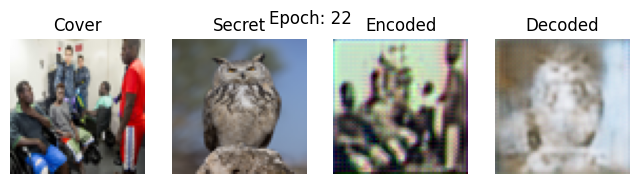

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 61ms/step


Epoch 23 | Batch:   0 of 400. Loss AE   14914.79 | Loss Rev1    1217.45:   4%|▍         | 1/25 [00:03<01:20,  3.35s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 23 | Batch:  16 of 400. Loss AE   16731.53 | Loss Rev1    2141.87:   8%|▊         | 2/25 [00:05<01:00,  2.65s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 23 | Batch:  32 of 400. Loss AE   15056.19 | Loss Rev1    2533.39:  12%|█▏        | 3/25 [00:07<00:53,  2.43s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 23 | Batch:  48 of 400. Loss AE   16066.34 | Loss Rev1    3593.22:  16%|█▌        | 4/25 [00:09<00:48,  2.33s/it]

1/1 [==============================] - 0s 41ms/step


Epoch 23 | Batch:  64 of 400. Loss AE   15168.46 | Loss Rev1    3292.63:  20%|██        | 5/25 [00:13<00:55,  2.78s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 23 | Batch:  80 of 400. Loss AE   14769.85 | Loss Rev1    3058.93:  24%|██▍       | 6/25 [00:15<00:48,  2.57s/it]

1/1 [==============================] - 0s 38ms/step


Epoch 23 | Batch:  96 of 400. Loss AE   14601.94 | Loss Rev1    3021.90:  28%|██▊       | 7/25 [00:17<00:44,  2.45s/it]

1/1 [==============================] - 0s 36ms/step


Epoch 23 | Batch: 112 of 400. Loss AE   14120.33 | Loss Rev1    2787.86:  32%|███▏      | 8/25 [00:19<00:40,  2.36s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 23 | Batch: 128 of 400. Loss AE   14874.10 | Loss Rev1    3168.56:  36%|███▌      | 9/25 [00:22<00:36,  2.30s/it]

1/1 [==============================] - 0s 37ms/step


Epoch 23 | Batch: 144 of 400. Loss AE   13850.20 | Loss Rev1    3164.04:  40%|████      | 10/25 [00:24<00:35,  2.35s/it]

1/1 [==============================] - 0s 75ms/step


Epoch 23 | Batch: 160 of 400. Loss AE   13717.81 | Loss Rev1    3089.95:  44%|████▍     | 11/25 [00:26<00:32,  2.31s/it]

1/1 [==============================] - 0s 32ms/step


Epoch 23 | Batch: 176 of 400. Loss AE   14206.93 | Loss Rev1    3124.52:  48%|████▊     | 12/25 [00:28<00:29,  2.27s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 23 | Batch: 192 of 400. Loss AE   13456.96 | Loss Rev1    3009.59:  52%|█████▏    | 13/25 [00:31<00:26,  2.24s/it]

1/1 [==============================] - 0s 36ms/step


Epoch 23 | Batch: 208 of 400. Loss AE   13317.15 | Loss Rev1    3019.56:  56%|█████▌    | 14/25 [00:33<00:24,  2.22s/it]

1/1 [==============================] - 0s 38ms/step


Epoch 23 | Batch: 224 of 400. Loss AE   12929.13 | Loss Rev1    2961.36:  60%|██████    | 15/25 [00:35<00:22,  2.21s/it]

1/1 [==============================] - 0s 38ms/step


Epoch 23 | Batch: 240 of 400. Loss AE   13185.03 | Loss Rev1    3270.85:  64%|██████▍   | 16/25 [00:37<00:20,  2.29s/it]

1/1 [==============================] - 0s 36ms/step


Epoch 23 | Batch: 256 of 400. Loss AE   13101.45 | Loss Rev1    3274.40:  68%|██████▊   | 17/25 [00:40<00:18,  2.26s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 23 | Batch: 272 of 400. Loss AE   12700.14 | Loss Rev1    3215.37:  72%|███████▏  | 18/25 [00:42<00:15,  2.23s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 23 | Batch: 288 of 400. Loss AE   12732.55 | Loss Rev1    3305.62:  76%|███████▌  | 19/25 [00:44<00:13,  2.21s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 23 | Batch: 304 of 400. Loss AE   12736.45 | Loss Rev1    3238.22:  80%|████████  | 20/25 [00:46<00:10,  2.20s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 23 | Batch: 320 of 400. Loss AE   12925.32 | Loss Rev1    3412.38:  84%|████████▍ | 21/25 [00:49<00:09,  2.28s/it]

1/1 [==============================] - 0s 52ms/step


Epoch 23 | Batch: 336 of 400. Loss AE   12851.71 | Loss Rev1    3429.66:  88%|████████▊ | 22/25 [00:51<00:06,  2.26s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 23 | Batch: 352 of 400. Loss AE   12794.00 | Loss Rev1    3456.70:  92%|█████████▏| 23/25 [00:53<00:04,  2.23s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 23 | Batch: 368 of 400. Loss AE   12370.46 | Loss Rev1    3380.84:  96%|█████████▌| 24/25 [00:55<00:02,  2.21s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 23 | Batch: 384 of 400. Loss AE   12097.73 | Loss Rev1    3407.78: 100%|██████████| 25/25 [00:58<00:00,  2.36s/it]


1/1 [==============================] - 0s 107ms/step - loss: 49031.2695



 33%|███▎      | 1/3 [01:00<02:00, 60.21s/it]

1/1 [==============================] - 0s 117ms/step - loss: 37317.8828



 67%|██████▋   | 2/3 [01:01<00:25, 25.55s/it]

1/1 [==============================] - 0s 118ms/step - loss: 30269.0332



100%|██████████| 3/3 [01:02<00:00, 20.89s/it]

1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 45ms/step


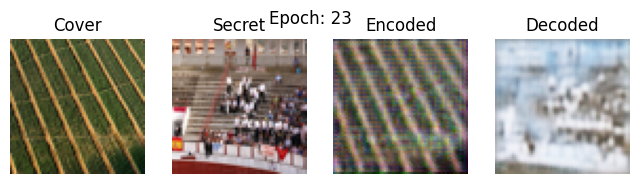

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


Epoch 24 | Batch:   0 of 400. Loss AE   10536.83 | Loss Rev1    3209.81:   4%|▍         | 1/25 [00:02<00:52,  2.21s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 24 | Batch:  16 of 400. Loss AE   10059.08 | Loss Rev1    2728.04:   8%|▊         | 2/25 [00:04<00:50,  2.17s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 24 | Batch:  32 of 400. Loss AE   10575.67 | Loss Rev1    2781.23:  12%|█▏        | 3/25 [00:06<00:47,  2.18s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 24 | Batch:  48 of 400. Loss AE    9160.93 | Loss Rev1    2351.54:  16%|█▌        | 4/25 [00:08<00:45,  2.18s/it]

1/1 [==============================] - 0s 39ms/step


Epoch 24 | Batch:  64 of 400. Loss AE    9883.47 | Loss Rev1    2716.21:  20%|██        | 5/25 [00:11<00:45,  2.28s/it]

1/1 [==============================] - 0s 37ms/step


Epoch 24 | Batch:  80 of 400. Loss AE   10571.66 | Loss Rev1    3760.16:  24%|██▍       | 6/25 [00:14<00:50,  2.64s/it]

1/1 [==============================] - 0s 39ms/step


Epoch 24 | Batch:  96 of 400. Loss AE   10111.87 | Loss Rev1    3510.65:  28%|██▊       | 7/25 [00:16<00:44,  2.49s/it]

1/1 [==============================] - 0s 39ms/step


Epoch 24 | Batch: 112 of 400. Loss AE   10154.15 | Loss Rev1    3525.24:  32%|███▏      | 8/25 [00:18<00:40,  2.39s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 24 | Batch: 128 of 400. Loss AE   10135.70 | Loss Rev1    3606.00:  36%|███▌      | 9/25 [00:22<00:42,  2.67s/it]

1/1 [==============================] - 0s 38ms/step


Epoch 24 | Batch: 144 of 400. Loss AE    9602.83 | Loss Rev1    3333.27:  40%|████      | 10/25 [00:25<00:42,  2.86s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 24 | Batch: 160 of 400. Loss AE    9715.99 | Loss Rev1    3355.77:  44%|████▍     | 11/25 [00:27<00:37,  2.66s/it]

1/1 [==============================] - 0s 44ms/step


Epoch 24 | Batch: 176 of 400. Loss AE    9974.16 | Loss Rev1    3538.17:  48%|████▊     | 12/25 [00:29<00:32,  2.51s/it]

1/1 [==============================] - 0s 40ms/step


Epoch 24 | Batch: 192 of 400. Loss AE   10215.46 | Loss Rev1    3445.30:  52%|█████▏    | 13/25 [00:32<00:28,  2.41s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 24 | Batch: 208 of 400. Loss AE   10650.14 | Loss Rev1    3538.95:  56%|█████▌    | 14/25 [00:34<00:25,  2.35s/it]

1/1 [==============================] - 0s 40ms/step


Epoch 24 | Batch: 224 of 400. Loss AE   10618.80 | Loss Rev1    3718.81:  60%|██████    | 15/25 [00:37<00:26,  2.64s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 24 | Batch: 240 of 400. Loss AE   10432.05 | Loss Rev1    3936.95:  64%|██████▍   | 16/25 [00:39<00:22,  2.51s/it]

1/1 [==============================] - 0s 37ms/step


Epoch 24 | Batch: 256 of 400. Loss AE   10557.83 | Loss Rev1    3799.47:  68%|██████▊   | 17/25 [00:41<00:19,  2.41s/it]

1/1 [==============================] - 0s 36ms/step


Epoch 24 | Batch: 272 of 400. Loss AE   10585.94 | Loss Rev1    3645.14:  72%|███████▏  | 18/25 [00:44<00:16,  2.35s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 24 | Batch: 288 of 400. Loss AE   10417.04 | Loss Rev1    3518.11:  76%|███████▌  | 19/25 [00:46<00:13,  2.30s/it]

1/1 [==============================] - 0s 38ms/step


Epoch 24 | Batch: 304 of 400. Loss AE   10451.22 | Loss Rev1    3614.16:  80%|████████  | 20/25 [00:49<00:12,  2.60s/it]

1/1 [==============================] - 0s 41ms/step


Epoch 24 | Batch: 320 of 400. Loss AE   10355.12 | Loss Rev1    3537.56:  84%|████████▍ | 21/25 [00:51<00:09,  2.47s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 24 | Batch: 336 of 400. Loss AE   10319.36 | Loss Rev1    3567.67:  88%|████████▊ | 22/25 [00:53<00:07,  2.39s/it]

1/1 [==============================] - 0s 38ms/step


Epoch 24 | Batch: 352 of 400. Loss AE   10110.78 | Loss Rev1    3547.80:  92%|█████████▏| 23/25 [00:56<00:04,  2.33s/it]

1/1 [==============================] - 0s 36ms/step


Epoch 24 | Batch: 368 of 400. Loss AE   10179.45 | Loss Rev1    3641.54:  96%|█████████▌| 24/25 [00:58<00:02,  2.28s/it]

1/1 [==============================] - 0s 42ms/step


Epoch 24 | Batch: 384 of 400. Loss AE   10420.20 | Loss Rev1    3735.67: 100%|██████████| 25/25 [01:01<00:00,  2.46s/it]


1/1 [==============================] - 0s 103ms/step - loss: 37430.1016



 33%|███▎      | 1/3 [01:02<02:05, 62.64s/it]

1/1 [==============================] - 0s 108ms/step - loss: 16498.0234



 67%|██████▋   | 2/3 [01:03<00:26, 26.55s/it]

1/1 [==============================] - 0s 107ms/step - loss: 11122.6914



100%|██████████| 3/3 [01:05<00:00, 21.75s/it]

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 34ms/step


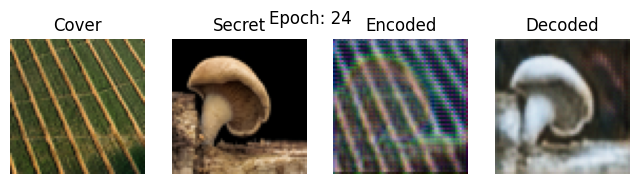

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 25 | Batch:   0 of 400. Loss AE    8494.06 | Loss Rev1    1610.74:   4%|▍         | 1/25 [00:02<00:52,  2.19s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 25 | Batch:  16 of 400. Loss AE   10370.14 | Loss Rev1    5555.26:   8%|▊         | 2/25 [00:04<00:50,  2.18s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 25 | Batch:  32 of 400. Loss AE   10560.76 | Loss Rev1    5859.16:  12%|█▏        | 3/25 [00:06<00:48,  2.19s/it]

1/1 [==============================] - 0s 47ms/step


Epoch 25 | Batch:  48 of 400. Loss AE    9797.41 | Loss Rev1    4694.47:  16%|█▌        | 4/25 [00:09<00:55,  2.64s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 25 | Batch:  64 of 400. Loss AE    9358.84 | Loss Rev1    4853.04:  20%|██        | 5/25 [00:12<00:49,  2.47s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 25 | Batch:  80 of 400. Loss AE    8588.62 | Loss Rev1    4387.07:  24%|██▍       | 6/25 [00:14<00:44,  2.37s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 25 | Batch:  96 of 400. Loss AE    8439.53 | Loss Rev1    3983.96:  28%|██▊       | 7/25 [00:16<00:41,  2.30s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 25 | Batch: 112 of 400. Loss AE    8518.84 | Loss Rev1    4448.71:  32%|███▏      | 8/25 [00:18<00:40,  2.35s/it]

1/1 [==============================] - 0s 50ms/step


Epoch 25 | Batch: 128 of 400. Loss AE    8315.41 | Loss Rev1    4165.94:  36%|███▌      | 9/25 [00:22<00:42,  2.67s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 25 | Batch: 144 of 400. Loss AE    8220.05 | Loss Rev1    3910.15:  40%|████      | 10/25 [00:24<00:37,  2.51s/it]

1/1 [==============================] - 0s 33ms/step


Epoch 25 | Batch: 160 of 400. Loss AE    7951.23 | Loss Rev1    3671.76:  44%|████▍     | 11/25 [00:26<00:33,  2.41s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 25 | Batch: 176 of 400. Loss AE    8889.32 | Loss Rev1    4182.70:  48%|████▊     | 12/25 [00:28<00:30,  2.34s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 25 | Batch: 192 of 400. Loss AE   10348.63 | Loss Rev1    4726.56:  52%|█████▏    | 13/25 [00:30<00:27,  2.29s/it]

1/1 [==============================] - 0s 35ms/step


Epoch 25 | Batch: 208 of 400. Loss AE   10250.67 | Loss Rev1    4847.97:  56%|█████▌    | 14/25 [00:34<00:28,  2.59s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 25 | Batch: 224 of 400. Loss AE   10112.46 | Loss Rev1    4600.33:  60%|██████    | 15/25 [00:36<00:24,  2.47s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 25 | Batch: 240 of 400. Loss AE   10040.42 | Loss Rev1    4437.29:  64%|██████▍   | 16/25 [00:38<00:21,  2.39s/it]

1/1 [==============================] - 0s 34ms/step


Epoch 25 | Batch: 256 of 400. Loss AE    9749.82 | Loss Rev1    4305.46:  68%|██████▊   | 17/25 [00:40<00:18,  2.32s/it]

1/1 [==============================] - 0s 37ms/step


Epoch 25 | Batch: 272 of 400. Loss AE    9938.27 | Loss Rev1    4348.98:  72%|███████▏  | 18/25 [00:42<00:15,  2.29s/it]

1/1 [==============================] - 0s 36ms/step


In [ ]:
from tqdm import tqdm

def display_progress(encoder, decoder, input_C, input_S1, epoch):
    # Choose a random index for visualization
    idx1 = np.random.choice(range(len(input_C)))
    idx2 = np.random.choice(range(len(input_S1)))

    # Get the images to be displayed
    cover_img = input_C[idx1]
    secret_img = input_S1[idx2]

    # Process the images through the network
    encoded_img = encoder.predict([secret_img[np.newaxis, ...], cover_img[np.newaxis, ...]])
    decoded = autoencoder_model.predict([secret_img[np.newaxis, ...], cover_img[np.newaxis, ...] ])
    decoded_S1, decoded_C = decoded[..., 0:3], decoded[..., 3:6]

    # Squeeze out the batch dimension
    decoded_S1 = np.squeeze(decoded_S1, axis=0)
    decoded_C = np.squeeze(decoded_C, axis=0)

    # Plot the results
    plt.figure(figsize=(8, 2))
    plt.subplot(1, 4, 1)
    plt.imshow(cover_img)
    plt.title("Cover")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(secret_img)
    plt.title("Secret")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(decoded_C)
    plt.title("Encoded")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(decoded_S1)
    plt.title("Decoded")
    plt.axis('off')

    plt.suptitle(f'Epoch: {epoch}')
    plt.show()

NB_EPOCHS = 50
BATCH_SIZE = 16

m_train = input_train_S1.shape[0]
m_val = input_val_S1.shape[0]
en_train_loss_history = []
dec_train_loss_history = []

en_val_loss_history = []
dec_val_loss_history = []


#loss_history2 = []
for epoch in range(NB_EPOCHS):
    np.random.shuffle(input_train_S1)

    np.random.shuffle(input_train_C)

    t = tqdm(range(0, input_train_S1.shape[0], BATCH_SIZE),mininterval=0)
    v = tqdm(range(0, input_val_S1.shape[0], BATCH_SIZE),mininterval=0)
    ae_train_loss = []
    rev_train_loss = []
    rev_val_loss = []
    ae_val_loss = []
    for idx in t:

        batch_train_S1 = input_train_S1[idx:min(idx + BATCH_SIZE, m_train)]
        batch_train_C = input_train_C[idx:min(idx + BATCH_SIZE, m_train)]

        C_prime = encoder_model.predict([batch_train_S1,  batch_train_C])

        ae_train_loss.append(autoencoder_model.train_on_batch(x=[batch_train_S1, batch_train_C], y=np.concatenate((batch_train_S1, batch_train_C), axis=-1)))
        rev_train_loss.append(reveal_model1.train_on_batch(x=C_prime,
                                              y=batch_train_S1))


        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        #K.set_value(autoencoder_model2.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model1.optimizer.lr, lr_schedule(epoch))


        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev1 {:10.2f}'.format(epoch + 1, idx, m_train, np.mean(ae_train_loss), np.mean(rev_train_loss)))

    for idx in v:

        batch_val_S1 = input_val_S1[idx:min(idx + BATCH_SIZE, m_val)]
        batch_val_C = input_val_C[idx:min(idx + BATCH_SIZE, m_val)]

        ae_val_loss.append(autoencoder_model.evaluate(x=[batch_val_S1, batch_val_C], y=np.concatenate((batch_val_S1, batch_val_C), axis=-1)))
        rev_val_loss.append(reveal_model1.evaluate(x=encoder_model.predict([batch_val_S1, batch_val_C]), y=batch_val_S1))


    display_progress(encoder_model, reveal_model1, input_val_C, input_val_S1, epoch+1)

    # autoencoder_model.save_weights('models/model3_'+str(epoch))
    #autoencoder_model2.save_weights('models/model'+str(epoch))

    en_train_loss_history.append(np.mean(ae_train_loss))
    dec_train_loss_history.append(np.mean(rev_train_loss))

    en_val_loss_history.append(np.mean(ae_val_loss))
    dec_val_loss_history.append(np.mean(rev_val_loss))


    #loss_history2.append(np.mean(ae_loss2))

In [ ]:
autoencoder_model.save_weights('model-(150,150)-160.h5')

1/1 [==============================] - 0s 19ms/step


<ipython-input-96-a8eb7fc3950a>:33: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return ssim(image1, image2, multichannel=True)


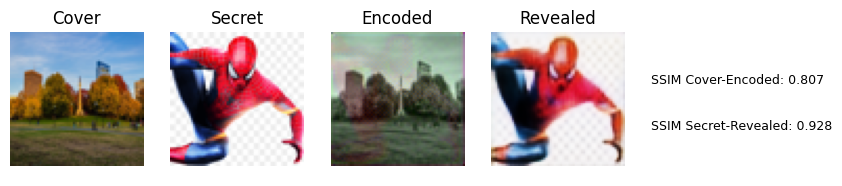

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from PIL import ImageFilter

IMG_SHAPE = (64, 64)  # Make sure this is the same size as used in training

def preprocess_image(image_path):
    """Loads and preprocesses an image."""
    img = Image.open(image_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(IMG_SHAPE)
    img_array = np.array(img)
    img_array = img_array.astype('float32') / 255.0
    return img_array

def sharpen_image(image_array):
    """Sharpens an image given as a NumPy array."""
    # Convert the NumPy array to a Pillow Image
    image = Image.fromarray((image_array * 255).astype(np.uint8))

    # Apply sharpening filter
    sharpened_image = image.filter(ImageFilter.SHARPEN)

    # Convert back to NumPy array
    sharpened_array = np.array(sharpened_image).astype('float32') / 255.0
    return sharpened_array

def calculate_ssim(image1, image2):
    """Calculate the Structural Similarity Index (SSIM) between two images."""
    return ssim(image1, image2, multichannel=True)

def process_and_predict(cover_img_path, secret_img_path, encoder, decoder):
    # Preprocess images
    cover_img = preprocess_image(cover_img_path)
    secret_img = preprocess_image(secret_img_path)

    # Process the images through the network
    encoded_img = encoder.predict([secret_img[np.newaxis, ...], cover_img[np.newaxis, ...], ])
    revealed_img = decoder.predict(encoded_img)

    # sharpened_encoded_img = sharpen_image(encoded_img[0])
    # sharpened_revealed_img = sharpen_image(revealed_img[0])

    # Calculate SSIM
    ssim_cover_encoded = calculate_ssim(cover_img, encoded_img[0])
    ssim_secret_revealed = calculate_ssim(secret_img, revealed_img[0])

    # Plot the results
    plt.figure(figsize=(10, 2))
    plt.subplot(1, 5, 1)
    plt.imshow(cover_img)
    plt.title("Cover")
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(secret_img)
    plt.title("Secret")
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(encoded_img[0])
    plt.title("Encoded")
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(revealed_img[0])
    plt.title("Revealed")
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.text(0, 0.6, f"SSIM Cover-Encoded: {ssim_cover_encoded:.3f}", fontsize=9)
    plt.text(0, 0.3, f"SSIM Secret-Revealed: {ssim_secret_revealed:.3f}", fontsize=9)
    plt.axis('off')

    plt.show()

# Example usage:
cover_img_path = '/content/House.jpg'
secret_img_path = '/content/park.jpg'
process_and_predict(cover_img_path, secret_img_path, encoder_model, reveal_model1)


1/1 [==============================] - 0s 22ms/step


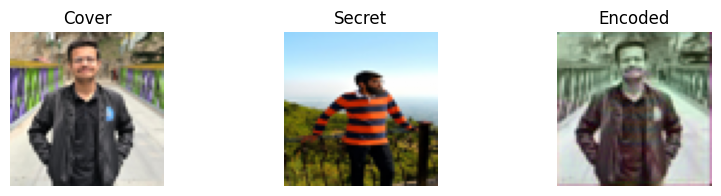

In [ ]:
import numpy as np
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from PIL import ImageFilter
import matplotlib.pyplot as plt

IMG_SHAPE = (64, 64)  # Make sure this is the same size as used in training

def preprocess_image(image_path):
    """Loads and preprocesses an image."""
    img = Image.open(image_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(IMG_SHAPE)
    img_array = np.array(img)
    img_array = img_array.astype('float32') / 255.0
    return img_array

def sharpen_image(image_array):
    """Sharpens an image given as a NumPy array."""
    # Convert the NumPy array to a Pillow Image
    image = Image.fromarray((image_array * 255).astype(np.uint8))

    # Apply sharpening filter
    sharpened_image = image.filter(ImageFilter.SHARPEN)

    # Convert back to NumPy array
    sharpened_array = np.array(sharpened_image).astype('float32') / 255.0
    return sharpened_array

def process_and_encode(cover_img_path, secret_img_path, encoder, save_encoded_path):
    # Preprocess images
    cover_img = preprocess_image(cover_img_path)
    secret_img = preprocess_image(secret_img_path)

    # Process the images through the network
    encoded_img = encoder.predict([secret_img[np.newaxis, ...], cover_img[np.newaxis, ...]])

    # Ensure the encoded image data is in the range [0, 1] for saving
    encoded_img_normalized = np.clip(encoded_img[0], 0, 1)

    blurred_img = cv2.GaussianBlur(encoded_img_normalized, (0, 0), 3)
    sharpened_img = cv2.addWeighted(encoded_img_normalized, 1.5, blurred_img, -0.5, 0)

    # Save the encoded image without introducing additional compression
    plt.imsave(save_encoded_path, encoded_img_normalized, format='png')

    # Plot the results
    fig, axs = plt.subplots(1, 3, figsize=(10, 2))
    axs[0].imshow(cover_img)
    axs[0].set_title("Cover")
    axs[0].axis('off')

    axs[1].imshow(secret_img)
    axs[1].set_title("Secret")
    axs[1].axis('off')

    axs[2].imshow(encoded_img_normalized)
    axs[2].set_title("Encoded")
    axs[2].axis('off')

    plt.show()

# You will need to define `encoder_model` before calling `process_and_encode`.
cover_img_path = '/content/jd.jpg'
secret_img_path = '/content/sam.jpg'
save_encoded_path = 'encoded_image2.png'
process_and_encode(cover_img_path, secret_img_path, encoder_model, save_encoded_path)


1/1 [==============================] - 0s 19ms/step


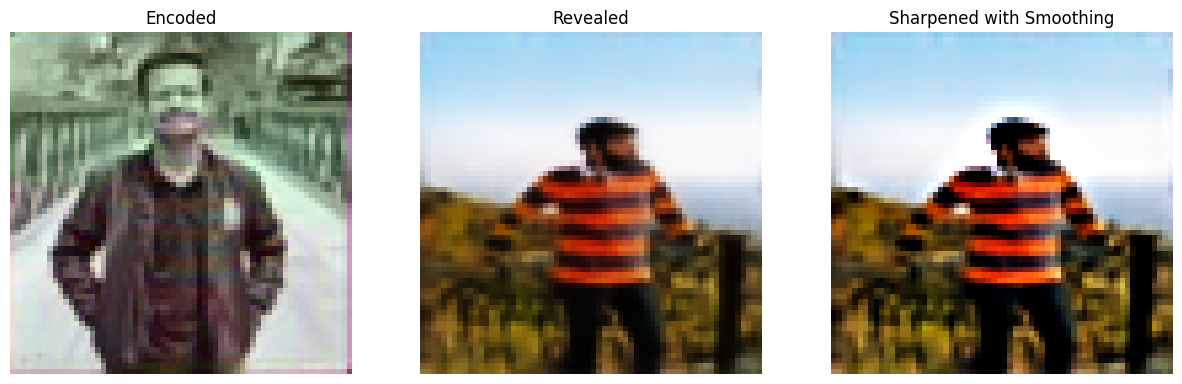

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def process_and_sharpen_with_smoothing(encoded_img_path, decoder):
    # Load the encoded image using plt
    encoded_image_array = plt.imread(encoded_img_path)

    # If the image has an alpha channel, consider removing it if the decoder expects 3 channels
    if encoded_image_array.shape[-1] == 4:
        encoded_image_array = encoded_image_array[..., :3]

    # Process the encoded image through the decoder
    revealed_img = decoder.predict(encoded_image_array[np.newaxis, ...])

    # Apply Gaussian smoothing followed by subtracting from the original image
    blurred_img = cv2.GaussianBlur(revealed_img[0], (0, 0), 3)
    sharpened_img = cv2.addWeighted(revealed_img[0], 1.5, blurred_img, -0.5, 0)

    # Plot the results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(encoded_image_array)
    plt.title("Encoded")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(revealed_img[0])
    plt.title("Revealed")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(sharpened_img)
    plt.title("Sharpened with Smoothing")
    plt.axis('off')

    plt.show()

# Example usage:
encoded_img_path = '/content/encoded_image2.png'  # Replace with the path to the encoded image
process_and_sharpen_with_smoothing(encoded_img_path, reveal_model1)


In [ ]:

decoded = autoencoder_model.predict([input_val_S1, input_val_C])
decoded_S1, decoded_C = decoded[...,0:3], decoded[...,3:6]

# Get absolute difference between the outputs and the expected values.
diff_S1, diff_C = np.abs(decoded_S1 - input_val_S1), np.abs(decoded_C - input_val_C)

2/2 [==============================] - 30s 10s/step


In [ ]:
def pixel_errors(input_S1,  input_C, decoded_S1,  decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_S1pixel = np.sqrt(np.mean(np.square(255*(input_S1 - decoded_S1))))

    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))

    return see_S1pixel,  see_Cpixel

import matplotlib.pyplot as plt

def pixel_histogram(diff_S1, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_S1flat = diff_S1.flatten()

    diff_Cflat = diff_C.flatten()

    fig = plt.figure(figsize=(15, 5))

    a = fig.add_subplot(1, 2, 1)
    imgplot = plt.hist(255 * diff_Cflat, 100, density=1, alpha=0.75, facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])

    a = fig.add_subplot(1, 2, 2)
    imgplot = plt.hist(255 * diff_S1flat, 100, density=1, alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the Secret image1.')
    plt.axis([0, 250, 0, 0.2])

    plt.show()


In [ ]:
# Print pixel-wise average errors in a 256 scale.
S1_error,  C_error = pixel_errors(input_val_S1,  input_val_C, decoded_S1, decoded_C)

print ("S1 error per pixel [0, 255]:", S1_error)

print ("C error per pixel [0, 255]:", C_error)

S1 error per pixel [0, 255]: 17.900423565049863
C error per pixel [0, 255]: 25.487253759713976


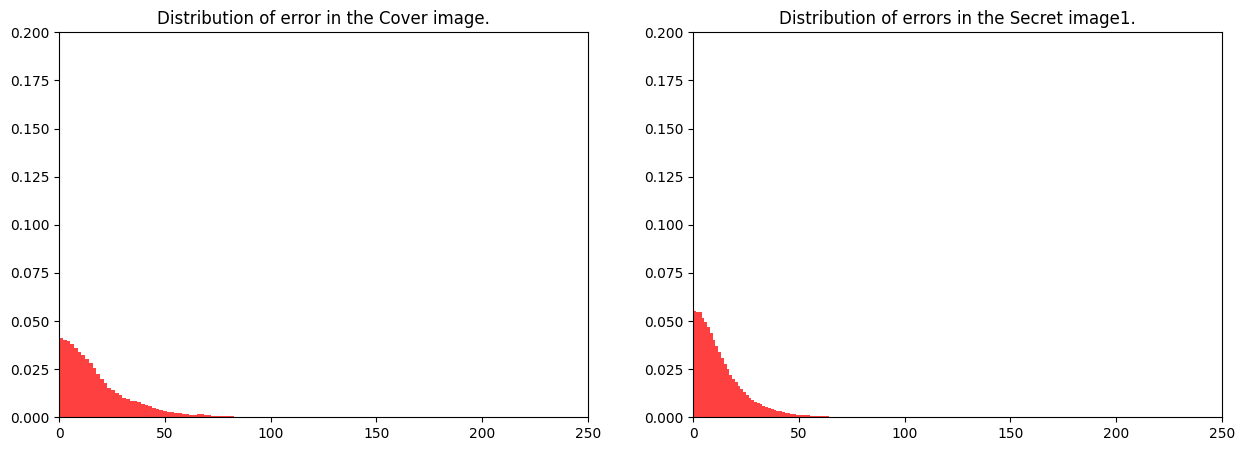

In [ ]:
# Plot distribution of errors in cover and secret images.
pixel_histogram(diff_S1, diff_C)

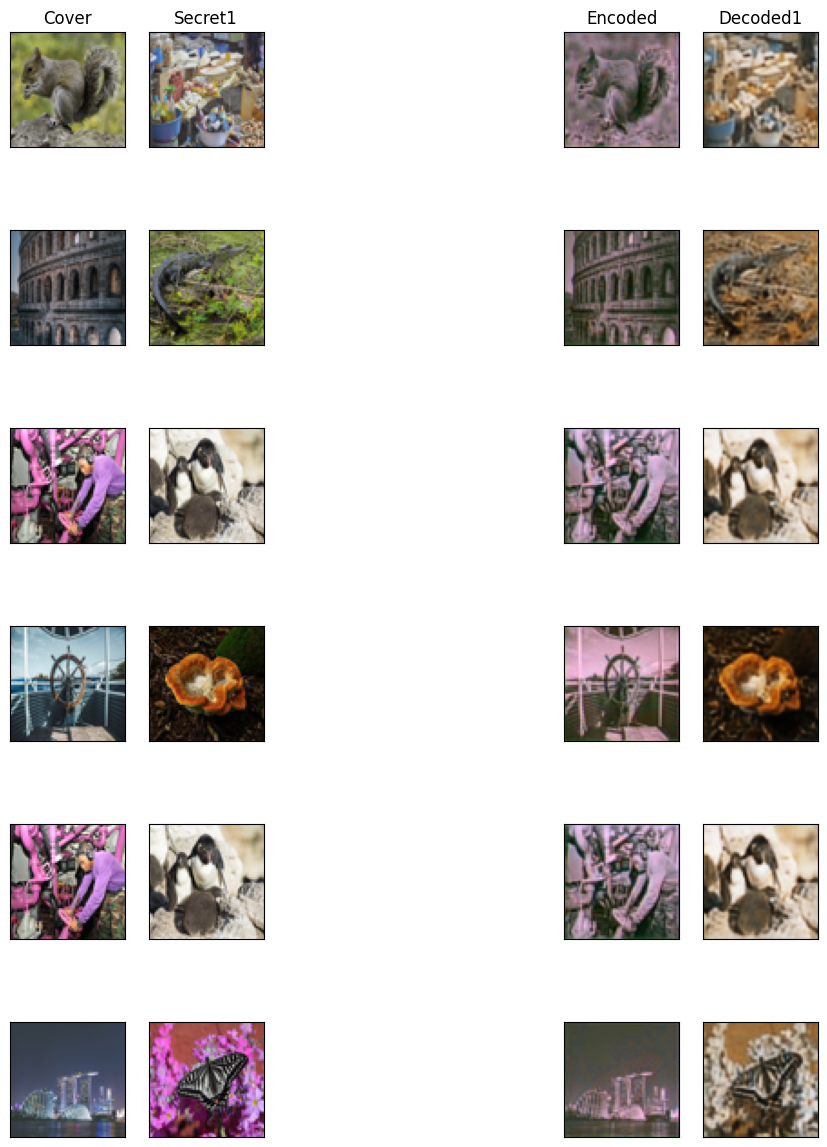

In [ ]:
# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 48) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 8 if SHOW_DIFF else 8

    show_image(input_val_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_val_S1[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret1')


    show_image(decoded_C[idx], n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Encoded')

    show_image(decoded_S1[idx], n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Decoded1')


    # if SHOW_DIFF:
    #     show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 9, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')

    #     show_image(np.multiply(diff_S1[idx], ENHANCE), n, n_col, i * n_col + 10, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret1')

    #     show_image(np.multiply(diff_S2[idx], ENHANCE), n, n_col, i * n_col + 11, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret2')

    #     show_image(np.multiply(diff_S3[idx], ENHANCE), n, n_col, i * n_col + 12, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret3')

plt.show()